# Description

Analyze trading execution quality.

In [1]:
%load_ext autoreload
%autoreload 2
import logging

import numpy as np
import pandas as pd

import core.config as cconfig
import core.finance as cofinanc
import core.finance.target_position_df_processing as cftpdp
import core.plotting as coplotti
import core.plotting.execution_stats as cplexsta
import core.statistics as costatis
import dataflow_amp.system.Cx as dtfamsysc
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import im_v2.common.universe as ivcu
import oms.broker.ccxt.ccxt_aggregation_functions as obccagfu
import oms.broker.ccxt.ccxt_execution_quality as obccexqu
import oms.broker.ccxt.ccxt_logger as obcccclo
import oms.child_order_quantity_computer.child_order_quantity_computer_instances as ocoqccoqci
import oms.order.order_converter as oororcon

/app/core/statistics/random_samples.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO: > cmd='/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-39f8d84d-b012-4200-b36c-93c5cd99b6c4.json'
INFO  # Git
  branch_name='CMTask7277_add_rounding'
  hash='87dcd7b21'
  # Last commits:
    * 87dcd7b21 Juraj Smeriga CmampTask7159_Call_submit_orders_in_TargetPositionAndOrderGenerator_for_each_bar (#7217) (   6 hours ago) Mon Feb 19 10:48:42 2024  (HEAD -> CMTask7277_add_rounding, origin/master, origin/HEAD, origin/CmTask7153_Switch_to_info_log_message_in_broker, master)
    * e4b8ed601 Sonaal   CmampTask7021_Onboard_OKX_OHLCV_perpetual_futures_realtime_data (#7060) (   8 hours ago) Mon Feb 19 08:36:55 2024           
    * 89043f127 Sonya Nikiforova Cm task7225 add a toc to a notebook 2 (#7254)                     (  14 hours ago) Mon Feb 19 02:19:04 2024           
# Machine info
  system=Linux
  node name=477b15f265ba
  release=5.15.0-1052-aws
  version=#57~20.04.1-Ubuntu SMP Mon Jan 15 17:04:56 UTC 2024
  machine=x86_64
  pr

# Config

In [3]:
config = cconfig.get_config_from_env()
if config:
    # Get config from env when running the notebook via the `run_notebook.py` script, e.g.,
    # in the system reconciliation flow.
    _LOG.info("Using config from env vars")
else:
    system_log_dir = "/shared_data/ecs/test/system_reconciliation/C12a/prod/20240219_150900.20240219_160600/system_log_dir.manual/process_forecasts"
    id_col = "asset_id"
    universe_version = "v7.5"
    vendor = "CCXT"
    mode = "trade"
    test_asset_id = 1464553467
    bar_duration = "3T"
    child_order_execution_freq = "60S"
    use_historical = True
    config_dict = {
        "meta": {"id_col": id_col, "use_historical": use_historical},
        "system_log_dir": system_log_dir,
        "ohlcv_market_data": {
            "vendor": vendor,
            "mode": mode,
            "universe": {
                "universe_version": universe_version,
                "test_asset_id": test_asset_id,
            },
        },
        "execution_parameters": {
            "bar_duration": bar_duration,
            "execution_freq": child_order_execution_freq,
        },
    }
    config = cconfig.Config.from_dict(config_dict)
print(config)

meta: 
  id_col: asset_id
  use_historical: True
system_log_dir: /shared_data/ecs/test/system_reconciliation/C12a/prod/20240219_150900.20240219_160600/system_log_dir.manual/process_forecasts
ohlcv_market_data: 
  vendor: CCXT
  mode: trade
  universe: 
    universe_version: v7.5
    test_asset_id: 1464553467
execution_parameters: 
  bar_duration: 3T
  execution_freq: 60S


In [4]:
# Init the log reader.
log_dir = config.get_and_mark_as_used(("system_log_dir",))
ccxt_log_reader = obcccclo.CcxtLogger(log_dir)

WARNING Path '/shared_data/ecs/test/system_reconciliation/C12a/prod/20240219_150900.20240219_160600/system_log_dir.manual/process_forecasts/args.json' doesn't exist!
WARNING Path '/shared_data/ecs/test/system_reconciliation/C12a/prod/20240219_150900.20240219_160600/system_log_dir.manual/process_forecasts/balances' doesn't exist!
WARNING Path '/shared_data/ecs/test/system_reconciliation/C12a/prod/20240219_150900.20240219_160600/system_log_dir.manual/process_forecasts/reduce_only/ccxt_child_order_responses' doesn't exist!
WARNING Path '/shared_data/ecs/test/system_reconciliation/C12a/prod/20240219_150900.20240219_160600/system_log_dir.manual/process_forecasts/reduce_only/oms_child_orders' doesn't exist!


In [5]:
# Print the Broker config.
try:
    broker_config = ccxt_log_reader.load_broker_config(abort_on_missing_data=True)
    print(hprint.to_pretty_str(broker_config))
    scheduler_type = broker_config["child_order_quantity_computer"]["object_type"]
except FileNotFoundError:
    _LOG.warning(
        "broker_config file not present in %s, assuming Dynamic Scheduling",
        log_dir,
    )
    scheduler_type = "DynamicSchedulingChildOrderQuantityComputer"

{'bid_ask_lookback': '60S',
 'child_order_quantity_computer': {'object_type': 'DynamicSchedulingChildOrderQuantityComputer'},
 'limit_price_computer': {'_volatility_multiple': [1.5,
                                                   0.7,
                                                   0.7,
                                                   0.6,
                                                   0.6,
                                                   0.5,
                                                   0.5,
                                                   10.0,
                                                   10.0,
                                                   10.0,
                                                   10.0,
                                                   10.0,
                                                   10.0,
                                                   10.0,
                                                   10.0,
                          

In [6]:
# Print the used Config, if any.
experiment_config = obcccclo.load_config_for_execution_analysis(log_dir)
if experiment_config:
    print(experiment_config)

INFO  Loading config from /shared_data/ecs/test/system_reconciliation/C12a/prod/20240219_150900.20240219_160600/system_log_dir.manual/system_config.output.values_as_strings.pkl
dag_config: ('False', 'None', "generate_features: 
  in_col_groups: [('close',), ('high',), ('low',), ('open',), ('volume',)]
  out_col_group: ()
  transformer_kwargs: 
    features: [('p1', [0.11406, 0.561195, 0.697379, 0.64538, -0.38615]), ('p2', [-0.835831, -0.48463, 0.160771, 1.045835, -0.82349])]
    bar_normalization_method: time
combine_features: 
  in_col_groups: [('p1',), ('p2',)]
  out_col_group: ()
  transformer_kwargs: 
    weights: [('p1', 3.4621), ('p2', 7.95919)]
compute_vol: 
  in_col_groups: [('close',), ('high',), ('low',), ('open',)]
  out_col_group: ()
  transformer_kwargs: 
    estimators: ['close', 'garman_klass']
    open_col: open
    high_col: high
    low_col: low
    close_col: close
    apply_log: True
    take_square_root: False
resample: 
  in_col_groups: [('close',), ('high',), ('l

In [7]:
# Get the test asset ID from the config.
test_asset_id = config.get_and_mark_as_used(
    ("ohlcv_market_data", "universe", "test_asset_id")
)
id_col = config.get_and_mark_as_used(("meta", "id_col"))

In [8]:
bar_duration = config.get_and_mark_as_used(
    ("execution_parameters", "bar_duration")
)
exec_freq = config.get_and_mark_as_used(
    ("execution_parameters", "execution_freq")
)
# Initialize scheduler according to it's type.
scheduler = ocoqccoqci.get_child_order_quantity_computer_instance1(scheduler_type)
# Get the range of expected number of child orders.
range_filter = scheduler.get_range_filter(bar_duration, exec_freq)

# Load and aggregate data

## Load CCXT data

In [9]:
data = ccxt_log_reader.load_all_data(
    convert_to_dataframe=True, abort_on_missing_data=False
)

WARNING Missing required data for 'args': continuing as per user request


Loading `/shared_data/ecs/test/system_reconciliation/C12a/prod/20240219_150900.20240219_160600/system_log_dir.…

Loading files from '/shared_data/ecs/test/system_reconciliation/C12a/prod/20240219_150900.20240219_160600/syst…

Loading `/shared_data/ecs/test/system_reconciliation/C12a/prod/20240219_150900.20240219_160600/system_log_dir.…

Loading `/shared_data/ecs/test/system_reconciliation/C12a/prod/20240219_150900.20240219_160600/system_log_dir.…

Loading `/shared_data/ecs/test/system_reconciliation/C12a/prod/20240219_150900.20240219_160600/system_log_dir.…

Loading `/shared_data/ecs/test/system_reconciliation/C12a/prod/20240219_150900.20240219_160600/system_log_dir.…

Loading `/shared_data/ecs/test/system_reconciliation/C12a/prod/20240219_150900.20240219_160600/system_log_dir.…

Loading `/shared_data/ecs/test/system_reconciliation/C12a/prod/20240219_150900.20240219_160600/system_log_dir.…

Loading `/shared_data/ecs/test/system_reconciliation/C12a/prod/20240219_150900.20240219_160600/system_log_dir.…

WARNING Missing required data for 'balances': continuing as per user request
WARNING Missing required data for 'reduce_only_order_responses': continuing as per user request


### Order responses

In [10]:
ccxt_order_response_df = data["ccxt_order_responses"]
ccxt_order_response_df.head(3)

,info,order,client_order_id,timestamp,datetime,last_trade_timestamp,lastUpdateTimestamp,symbol,order_type,time_in_force,post_only,reduce_only,side,order_price,triggerPrice,order_amount,cost,average,filled,remaining,status,fee,trades,fees,stop_price,takeProfitPrice,stopLossPrice,order_update_timestamp,order_update_datetime
0,"{'orderId': '8389765653578981373', 'symbol': '...",8389765653578981373,x-xcKtGhcud46e0ab545e2c958d3e90d,1708355345898,2024-02-19T15:09:05.898Z,NaN,1708355345898,ETH/USDT:USDT,limit,GTC,False,False,sell,2906.69,None,0.206,0.0,NaN,0.0,0.206,open,None,[],[],None,None,None,1708355345898,2024-02-19 15:09:05.898000+00:00
1,"{'orderId': '8389765653578987144', 'symbol': '...",8389765653578987144,x-xcKtGhcuaf11b668af80f400a926e,1708355350242,2024-02-19T15:09:10.242Z,NaN,1708355350242,ETH/USDT:USDT,limit,GTC,False,False,sell,2906.25,None,0.206,0.0,NaN,0.0,0.206,open,None,[],[],None,None,None,1708355350242,2024-02-19 15:09:10.242000+00:00
2,"{'orderId': '8389765653579017173', 'symbol': '...",8389765653579017173,x-xcKtGhcu3269d72fa23cff90fb9a16,1708355360201,2024-02-19T15:09:20.201Z,NaN,1708355360201,ETH/USDT:USDT,limit,GTC,False,False,sell,2905.92,None,0.206,0.0,NaN,0.0,0.206,open,None,[],[],None,None,None,1708355360201,2024-02-19 15:09:20.201000+00:00


In [11]:
ccxt_order_response_df.loc[1]["info"]

{'orderId': '8389765653578987144',
 'symbol': 'ETHUSDT',
 'status': 'NEW',
 'clientOrderId': 'x-xcKtGhcuaf11b668af80f400a926e',
 'price': '2906.25',
 'avgPrice': '0.00',
 'origQty': '0.206',
 'executedQty': '0.000',
 'cumQty': '0.000',
 'cumQuote': '0.00000',
 'timeInForce': 'GTC',
 'type': 'LIMIT',
 'reduceOnly': False,
 'closePosition': False,
 'side': 'SELL',
 'positionSide': 'BOTH',
 'stopPrice': '0.00',
 'workingType': 'CONTRACT_PRICE',
 'priceProtect': False,
 'origType': 'LIMIT',
 'priceMatch': 'NONE',
 'selfTradePreventionMode': 'NONE',
 'goodTillDate': '0',
 'updateTime': '1708355350242'}

In [12]:
ccxt_order_response_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   info                    99 non-null     object             
 1   order                   99 non-null     int64              
 2   client_order_id         99 non-null     object             
 3   timestamp               99 non-null     int64              
 4   datetime                99 non-null     object             
 5   last_trade_timestamp    4 non-null      float64            
 6   lastUpdateTimestamp     99 non-null     int64              
 7   symbol                  99 non-null     object             
 8   order_type              99 non-null     object             
 9   time_in_force           99 non-null     object             
 10  post_only               99 non-null     bool               
 11  reduce_only             99 non-null     bool   

### OMS child orders

In [13]:
child_order_df = data["oms_child_orders"]
# TODO: group by asset, agg by mean total_vol_to_spread_bps, chart.
child_order_df.head(3)

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params,volatility_multiple,wave_id,num_data_points,exchange_timestamp,knowledge_timestamp,end_download_timestamp,latest_bid_size,latest_ask_size,num_data_points_resampled,scaling_multiplier,bid_vol,bid_vol_bps,latest_bid_price,ask_vol,ask_vol_bps,latest_ask_price,total_vol,latest_mid_price,total_vol_bps,spread,spread_bps,total_vol_to_spread_bps,limit_price,ccxt_id,name,attempt_num
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,2024-02-19 15:09:05.307975+00:00,1464553467,limit,2024-02-19 15:09:05.307975+00:00,2024-02-19 15:09:10+00:00,0.0,-0.206,America/New_York,{'stats': {'_submit_twap_child_order::wave_id'...,1.5,0,289,2024-02-19 15:09:04.730000+00:00,2024-02-19 15:09:04.848809+00:00,2024-02-19 15:09:04.826719+00:00,87.550,110.968,598,10.0,0.466068,1.603819,2905.99,0.467002,1.607025,2906.00,0.466535,2905.995,1.605423,0.01,0.034412,46.653504,2906.69,8389765653578981373,3,1
5,2024-02-19 15:09:10.226783+00:00,1464553467,limit,2024-02-19 15:09:10.226783+00:00,2024-02-19 15:09:20+00:00,0.0,-0.206,America/New_York,{'stats': {'_submit_twap_child_order::wave_id'...,0.7,1,288,2024-02-19 15:09:09.704000+00:00,2024-02-19 15:09:09.794508+00:00,2024-02-19 15:09:09.779835+00:00,36.281,105.437,597,10.0,0.377625,1.299471,2905.99,0.378779,1.303436,2906.00,0.378202,2905.995,1.301455,0.01,0.034412,37.820221,2906.25,8389765653578987144,5,1
7,2024-02-19 15:09:20.186431+00:00,1464553467,limit,2024-02-19 15:09:20.186431+00:00,2024-02-19 15:09:30+00:00,0.0,-0.206,America/New_York,{'stats': {'_submit_twap_child_order::wave_id'...,0.7,2,289,2024-02-19 15:09:19.688000+00:00,2024-02-19 15:09:19.724792+00:00,2024-02-19 15:09:19.707217+00:00,16.870,34.296,598,10.0,0.374233,1.287945,2905.66,0.375395,1.291939,2905.67,0.374814,2905.665,1.289943,0.01,0.034416,37.481430,2905.92,8389765653579017173,7,1


In [14]:
child_order_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117 entries, 3 to 140
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   creation_timestamp         117 non-null    datetime64[ns, UTC]
 1   asset_id                   117 non-null    int64              
 2   type_                      117 non-null    object             
 3   start_timestamp            117 non-null    datetime64[ns, UTC]
 4   end_timestamp              117 non-null    datetime64[ns, UTC]
 5   curr_num_shares            117 non-null    float64            
 6   diff_num_shares            117 non-null    float64            
 7   tz                         117 non-null    object             
 8   extra_params               117 non-null    object             
 9   volatility_multiple        117 non-null    float64            
 10  wave_id                    117 non-null    int64              
 11  num_data_po

### CCXT fills (trades)

In [15]:
fills_df = data["ccxt_trades"]
# Annotate fills with child order wave ID.
fills_df = obccexqu.annotate_fills_df_with_wave_id(fills_df, child_order_df)
fills_df.head(3)

,timestamp,datetime,symbol,asset_id,id,order,side,takerOrMaker,price,amount,cost,transaction_cost,fees_currency,realized_pnl,first_timestamp,last_timestamp,first_datetime,last_datetime,buy_count,sell_count,taker_count,maker_count,buy_volume,sell_volume,taker_volume,maker_volume,buy_notional,sell_notional,taker_notional,maker_notional,wave_id
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-02-19 15:09:28.147000+00:00,2024-02-19 15:09:28.147000+00:00,2024-02-19 15:09:28.147000+00:00,BTC/USDT:USDT,1467591036,4610979912,268411816575,sell,maker,52182.40,0.017,887.10080,0.177420,USDT,0.00000,2024-02-19 15:09:28.147000+00:00,2024-02-19 15:09:28.147000+00:00,2024-02-19 15:09:28.147000+00:00,2024-02-19 15:09:28.147000+00:00,0,1,0,1,0.000,0.017,0.000,0.017,0.00000,887.10080,0.00000,887.10080,2
2024-02-19 15:09:26.149000+00:00,2024-02-19 15:09:26.149000+00:00,2024-02-19 15:09:26.149000+00:00,ETH/USDT:USDT,1464553467,3632136126,8389765653579017173,sell,maker,2905.92,0.206,598.61952,0.119724,USDT,0.00000,2024-02-19 15:09:26.149000+00:00,2024-02-19 15:09:26.149000+00:00,2024-02-19 15:09:26.149000+00:00,2024-02-19 15:09:26.149000+00:00,0,1,0,1,0.000,0.206,0.000,0.206,0.00000,598.61952,0.00000,598.61952,2
2024-02-19 15:18:20.200000+00:00,2024-02-19 15:18:20.200000+00:00,2024-02-19 15:18:20.200000+00:00,ETH/USDT:USDT,1464553467,3632150681,8389765653580776865,buy,taker,2909.55,0.515,1498.41825,0.749209,USDT,-0.74778,2024-02-19 15:18:20.200000+00:00,2024-02-19 15:18:20.200000+00:00,2024-02-19 15:18:20.200000+00:00,2024-02-19 15:18:20.200000+00:00,1,0,1,0,0.515,0.000,0.515,0.000,1498.41825,0.00000,1498.41825,0.00000,2


In [16]:
fills_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22 entries, 2024-02-19 15:09:28.147000+00:00 to 2024-02-19 16:07:00.644000+00:00
Data columns (total 31 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   timestamp         22 non-null     datetime64[ns, UTC]
 1   datetime          22 non-null     datetime64[ns, UTC]
 2   symbol            22 non-null     object             
 3   asset_id          22 non-null     int64              
 4   id                22 non-null     int64              
 5   order             22 non-null     int64              
 6   side              22 non-null     object             
 7   takerOrMaker      22 non-null     object             
 8   price             22 non-null     float64            
 9   amount            22 non-null     float64            
 10  cost              22 non-null     float64            
 11  transaction_cost  22 non-null     float64            
 12  fe

### OMS parent orders

In [17]:
parent_order_df = data["oms_parent_orders"]
parent_order_df.head(3)

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params
order_id,,,,,,,,,
0,2024-02-19 15:09:04.815286+00:00,1467591036,price@twap,2024-02-19 15:09:04.815286+00:00,2024-02-19 15:12:00+00:00,0.000,-0.017,America/New_York,"{'ccxt_symbol': 'BTC/USDT:USDT', 'stats': {'_s..."
1,2024-02-19 15:09:04.815286+00:00,1464553467,price@twap,2024-02-19 15:09:04.815286+00:00,2024-02-19 15:12:00+00:00,0.000,-0.206,America/New_York,"{'ccxt_symbol': 'ETH/USDT:USDT', 'stats': {'_s..."
8,2024-02-19 15:12:04.523893+00:00,1464553467,price@twap,2024-02-19 15:12:04.523893+00:00,2024-02-19 15:15:00+00:00,-0.206,-0.005,America/New_York,"{'ccxt_symbol': 'ETH/USDT:USDT', 'stats': {'_s..."


In [18]:
parent_order_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, 0 to 131
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   creation_timestamp  24 non-null     datetime64[ns, UTC]
 1   asset_id            24 non-null     int64              
 2   type_               24 non-null     object             
 3   start_timestamp     24 non-null     datetime64[ns, UTC]
 4   end_timestamp       24 non-null     datetime64[ns, UTC]
 5   curr_num_shares     24 non-null     float64            
 6   diff_num_shares     24 non-null     float64            
 7   tz                  24 non-null     object             
 8   extra_params        24 non-null     object             
dtypes: datetime64[ns, UTC](3), float64(2), int64(1), object(3)
memory usage: 1.9+ KB


## Aggregate CCXT Data

In [19]:
bar_duration = config.get_and_mark_as_used(
    ("execution_parameters", "bar_duration")
)
# TODO(Paul): Look into adding tqdm.
# Aggregate order responses by bar.
bar_ccxt_order_aggregation = obccagfu.aggregate_ccxt_orders_by_bar(
    ccxt_order_response_df, bar_duration
)
# Aggregate fills by order.
ccxt_order_fills = obccagfu.aggregate_fills_by_order(fills_df)
# Aggregate fills by bar.
bar_fills = obccagfu.aggregate_fills_by_bar(
    fills_df, bar_duration, groupby_id_col=id_col
)
# Aggregate buy/sell trade prices by bar.
trade_prices = obccagfu.compute_buy_sell_prices_by_bar(
    fills_df, bar_duration, groupby_id_col=id_col
)
# Aggregate OMS child orders.
bar_child_order_aggregation = obccagfu.aggregate_child_limit_orders_by_bar(
    child_order_df, bar_duration
)

In [20]:
bar_ccxt_order_aggregation.head(3)

order_count            buy_order_count            buy_limit_twap               buy_limit_vwap               buy_amount            buy_notional            sell_order_count            sell_limit_twap            sell_limit_vwap            sell_amount            sell_notional           
asset_id                   1464553467 1467591036      1464553467 1467591036     1464553467    1467591036     1464553467    1467591036 1464553467 1467591036   1464553467 1467591036       1464553467 1467591036      1464553467 1467591036      1464553467 1467591036  1464553467 1467591036    1464553467 1467591036
bar_end_datetime                                                                                                                                                                                                                                                                                                     
2024-02-19 15:12:00+00:00           3          3               0          0            NaN           NaN            NaN           NaN        NaN        NaN          NaN        NaN                3          3     2906.286667  52187.200     2906.286667  52187.200       0.618      0.051    1796.08516  2661.5472
2024-02-19 15:21:00+00:00           3          6               3          6    2909.436667  52231.033333    2909.436667  52231.033333      1.545      0.168   4495.07965  8774.8136                0          0             NaN        NaN             NaN        NaN         NaN        NaN           NaN        NaN
2024-02-19 15:24:00+00:00          18          4               0          0            NaN           NaN            NaN           NaN        NaN        NaN          NaN        NaN               18          4     2919.165000  52313.975     2919.165000  52313.975      11.124      0.088   32472.79146  4603.6298

In [21]:
ccxt_order_fills.head(3)

,first_timestamp,last_timestamp,first_datetime,last_datetime,symbol,asset_id,buy_count,sell_count,taker_count,maker_count,buy_volume,sell_volume,taker_volume,maker_volume,buy_notional,sell_notional,taker_notional,maker_notional,price,amount,cost,transaction_cost,realized_pnl
order,,,,,,,,,,,,,,,,,,,,,,,
268411816575,2024-02-19 15:09:28.147000+00:00,2024-02-19 15:09:28.147000+00:00,2024-02-19 15:09:28.147000+00:00,2024-02-19 15:09:28.147000+00:00,BTC/USDT:USDT,1467591036,0,1,0,1,0.000,0.017,0.0,0.017,0.0000,887.1008,0.0,887.1008,52182.4,0.017,887.1008,0.177420,0.0000
268414960060,2024-02-19 15:18:55.554000+00:00,2024-02-19 15:18:55.554000+00:00,2024-02-19 15:18:55.554000+00:00,2024-02-19 15:18:55.554000+00:00,BTC/USDT:USDT,1467591036,1,0,0,1,0.028,0.000,0.0,0.028,1462.7284,0.0000,0.0,1462.7284,52240.3,0.028,1462.7284,0.292546,-0.9843
268416737737,2024-02-19 15:21:31.209000+00:00,2024-02-19 15:21:31.209000+00:00,2024-02-19 15:21:31.209000+00:00,2024-02-19 15:21:31.209000+00:00,BTC/USDT:USDT,1467591036,0,1,0,1,0.000,0.022,0.0,0.022,0.0000,1150.7584,0.0,1150.7584,52307.2,0.022,1150.7584,0.230152,0.7359


In [22]:
bar_fills.head(3)

first_timestamp                   last_timestamp                   first_datetime                    last_datetime         symbol    asset_id  buy_count  sell_count  taker_count  maker_count  buy_volume  sell_volume  taker_volume  maker_volume  buy_notional  sell_notional  taker_notional  maker_notional     price  amount        cost  transaction_cost  realized_pnl
bar_end_datetime          asset_id                                                                                                                                                                                                                                                                                                                                                                                                  
2024-02-19 15:12:00+00:00 1464553467 2024-02-19 15:09:26.149000+00:00 2024-02-19 15:09:26.149000+00:00 2024-02-19 15:09:26.149000+00:00 2024-02-19 15:09:26.149000+00:00  ETH/USDT:USDT  1464553467          0           1            0            1       0.000        0.206         0.000         0.206       0.00000      598.61952         0.00000       598.61952   2905.92   0.206   598.61952          0.119724       0.00000
                          1467591036 2024-02-19 15:09:28.147000+00:00 2024-02-19 15:09:28.147000+00:00 2024-02-19 15:09:28.147000+00:00 2024-02-19 15:09:28.147000+00:00  BTC/USDT:USDT  1467591036          0           1            0            1       0.000        0.017         0.000         0.017       0.00000      887.10080         0.00000       887.10080  52182.40   0.017   887.10080          0.177420       0.00000
2024-02-19 15:21:00+00:00 1464553467 2024-02-19 15:18:20.200000+00:00 2024-02-19 15:18:20.200000+00:00 2024-02-19 15:18:20.200000+00:00 2024-02-19 15:18:20.200000+00:00  ETH/USDT:USDT  1464553467          1           0            1            0       0.515        0.000         0.515         0.000    1498.41825        0.00000      1498.41825         0.00000   2909.55   0.515  1498.41825          0.749209      -0.74778

In [23]:
trade_prices.head(3)

buy_trade_price            sell_trade_price           
asset_id                       1464553467 1467591036       1464553467 1467591036
bar_end_datetime                                                                
2024-02-19 15:12:00+00:00             NaN        NaN          2905.92    52182.4
2024-02-19 15:21:00+00:00         2909.55    52240.3              NaN        NaN
2024-02-19 15:24:00+00:00             NaN        NaN              NaN    52307.2

In [24]:
bar_child_order_aggregation.head(3)

order_count                                  buy_order_count            buy_limit_twap               buy_limit_vwap               buy_amount            buy_notional            sell_order_count            sell_limit_twap            sell_limit_vwap            sell_amount            sell_notional           
asset_id                   1464553467 1467591036 1464553467 1467591036      1464553467 1467591036     1464553467    1467591036     1464553467    1467591036 1464553467 1467591036   1464553467 1467591036       1464553467 1467591036      1464553467 1467591036      1464553467 1467591036  1464553467 1467591036    1464553467 1467591036
bar_end_datetime                                                                                                                                                                                                                                                                                                                           
2024-02-19 15:12:00+00:00         NaN        NaN        3.0        3.0             NaN        NaN            NaN           NaN            NaN           NaN        NaN        NaN          NaN        NaN              3.0        3.0     2906.286667    52187.2     2906.286667    52187.2       0.618      0.051    1796.08516  2661.5472
2024-02-19 15:15:00+00:00         NaN        NaN       18.0        0.0             NaN        NaN            NaN           NaN            NaN           NaN        NaN        NaN          NaN        NaN             18.0        0.0     2909.502778        NaN     2909.502778        NaN       0.090        NaN     261.85525        NaN
2024-02-19 15:21:00+00:00         3.0        6.0        NaN        NaN             3.0        6.0    2909.436667  52231.033333    2909.436667  52231.033333      1.545      0.168   4495.07965  8774.8136              NaN        NaN             NaN        NaN             NaN        NaN         NaN        NaN           NaN        NaN

In [25]:
cofinanc.get_asset_slice(bar_ccxt_order_aggregation, test_asset_id)

,order_count,buy_order_count,buy_limit_twap,buy_limit_vwap,buy_amount,buy_notional,sell_order_count,sell_limit_twap,sell_limit_vwap,sell_amount,sell_notional
bar_end_datetime,,,,,,,,,,,
2024-02-19 15:12:00+00:00,3.0,0.0,NaN,NaN,NaN,NaN,3.0,2906.286667,2906.286667,0.618,1796.08516
2024-02-19 15:21:00+00:00,3.0,3.0,2909.436667,2909.436667,1.545,4495.07965,0.0,NaN,NaN,NaN,NaN
2024-02-19 15:24:00+00:00,18.0,0.0,NaN,NaN,NaN,NaN,18.0,2919.165000,2919.165000,11.124,32472.79146
2024-02-19 15:27:00+00:00,4.0,0.0,NaN,NaN,NaN,NaN,4.0,2918.415000,2918.415000,2.468,7202.64822
2024-02-19 15:33:00+00:00,1.0,1.0,2915.080000,2915.080000,0.617,1798.60436,0.0,NaN,NaN,NaN,NaN
2024-02-19 15:36:00+00:00,2.0,0.0,NaN,NaN,NaN,NaN,2.0,2912.640000,2912.641512,0.205,597.09151
2024-02-19 15:39:00+00:00,18.0,18.0,2905.356111,2905.356111,1.854,5386.53023,0.0,NaN,NaN,NaN,NaN
2024-02-19 15:42:00+00:00,4.0,0.0,NaN,NaN,NaN,NaN,4.0,2907.955000,2907.955000,2.068,6013.65094
2024-02-19 15:45:00+00:00,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


### Align CCXT orders and fills

In [26]:
# Get filled and unfilled CCXT orders.
filled_ccxt_orders, unfilled_ccxt_orders = obccexqu.align_ccxt_orders_and_fills(
    ccxt_order_response_df, fills_df
)

In [27]:
filled_ccxt_orders.head(3)

,order_type,time_in_force,post_only,reduce_only,side,order_price,stop_price,order_amount,order_update_timestamp,order_update_datetime,first_timestamp,last_timestamp,first_datetime,last_datetime,symbol,asset_id,buy_count,sell_count,taker_count,maker_count,buy_volume,sell_volume,taker_volume,maker_volume,buy_notional,sell_notional,taker_notional,maker_notional,price,amount,cost,transaction_cost,realized_pnl
order,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8389765653579017173,limit,GTC,False,False,sell,2905.92,None,0.206,1708355360201,2024-02-19 15:09:20.201000+00:00,2024-02-19 15:09:26.149000+00:00,2024-02-19 15:09:26.149000+00:00,2024-02-19 15:09:26.149000+00:00,2024-02-19 15:09:26.149000+00:00,ETH/USDT:USDT,1464553467,0,1,0,1,0.000,0.206,0.000,0.206,0.00000,598.61952,0.00000,598.61952,2905.92,0.206,598.61952,0.119724,0.00000
8389765653580776865,limit,GTC,False,False,buy,2909.58,None,0.515,1708355900200,2024-02-19 15:18:20.200000+00:00,2024-02-19 15:18:20.200000+00:00,2024-02-19 15:18:20.200000+00:00,2024-02-19 15:18:20.200000+00:00,2024-02-19 15:18:20.200000+00:00,ETH/USDT:USDT,1464553467,1,0,1,0,0.515,0.000,0.515,0.000,1498.41825,0.00000,1498.41825,0.00000,2909.55,0.515,1498.41825,0.749209,-0.74778
8389765653582385100,limit,GTC,False,False,sell,2917.43,None,0.617,1708356270170,2024-02-19 15:24:30.170000+00:00,2024-02-19 15:24:30.170000+00:00,2024-02-19 15:24:30.170000+00:00,2024-02-19 15:24:30.170000+00:00,2024-02-19 15:24:30.170000+00:00,ETH/USDT:USDT,1464553467,0,1,1,0,0.000,0.617,0.617,0.000,0.00000,1800.23941,1800.23941,0.00000,2917.73,0.617,1800.23941,0.900120,2.52762


In [28]:
unfilled_ccxt_orders.head(3)

,order_type,time_in_force,post_only,reduce_only,side,order_price,stop_price,order_amount,order_update_timestamp,order_update_datetime
order,,,,,,,,,,
268411740451,limit,GTC,False,False,sell,52188.8,None,0.017,1708355345887,2024-02-19 15:09:05.887000+00:00
268411793370,limit,GTC,False,False,sell,52190.4,None,0.017,1708355350240,2024-02-19 15:09:10.240000+00:00
268414658912,limit,GTC,False,False,buy,52222.1,None,0.028,1708355884792,2024-02-19 15:18:04.792000+00:00


## Load OHLCV data

In [29]:
# TODO(Paul): Refine the cuts around the first and last bars.
start_timestamp = bar_fills["first_datetime"].min() - pd.Timedelta(bar_duration)
_LOG.info("start_timestamp=%s", start_timestamp)
end_timestamp = bar_fills["last_datetime"].max() + pd.Timedelta(bar_duration)
_LOG.info("end_timestamp=%s", end_timestamp)

INFO  start_timestamp=2024-02-19 15:06:26.149000+00:00
INFO  end_timestamp=2024-02-19 16:10:00.644000+00:00


In [30]:
universe_version = config.get_and_mark_as_used(
    ("ohlcv_market_data", "universe", "universe_version")
)
vendor = config.get_and_mark_as_used(
    (
        "ohlcv_market_data",
        "vendor",
    )
)
mode = config.get_and_mark_as_used(
    (
        "ohlcv_market_data",
        "mode",
    )
)
# Get asset ids.
asset_ids = ivcu.get_vendor_universe_as_asset_ids(universe_version, vendor, mode)
# Get prod `MarketData`.
db_stage = "preprod"
market_data = dtfamsysc.get_Cx_RealTimeMarketData_prod_instance1(
    asset_ids, db_stage
)
# Load and resample OHLCV data.
ohlcv_bars = dtfamsysc.load_and_resample_ohlcv_data(
    market_data,
    start_timestamp,
    end_timestamp,
    bar_duration,
)
hpandas.df_to_str(ohlcv_bars, num_rows=5, log_level=logging.INFO)

INFO  Unable to fetch DB credentials from environment variables: 
	'POSTGRES_HOST'
	Attempting env file method.
INFO  Unable to fetch DB credentials from env file: 
	
################################################################################
* Failed assertion *
File '/app/im_v2/devops/env/preprod.im_db_config.env' doesn't exist
################################################################################

	Attempting AWS SecretsManager method.
INFO  Fetching secret: preprod.im_data_db
INFO  Created preprod DB connection: 
 None


/app/helpers/hsql_implementation.py:582: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


INFO  fit_intervals=[(Timestamp('2024-02-19 15:06:26.149000+0000', tz='UTC'), Timestamp('2024-02-19 16:10:00.644000+0000', tz='UTC'))]


close                  high                   low                  open                    twap                   volume                    vwap              
                          1464553467 1467591036 1464553467 1467591036 1464553467 1467591036 1464553467 1467591036   1464553467    1467591036 1464553467 1467591036   1464553467    1467591036
2024-02-19 10:09:00-05:00    2905.98    52179.0    2907.98    52230.5    2904.48    52170.3    2906.47    52194.6  2905.943333  52187.866667   2082.236    405.608  2905.813907  52196.151006
2024-02-19 10:12:00-05:00    2907.94    52200.0    2908.87    52213.4    2905.28    52178.1    2905.99    52179.1  2907.606667  52196.466667   3658.224    223.449  2907.544434  52198.199541
                                 ...        ...        ...        ...        ...        ...        ...        ...          ...           ...        ...        ...          ...           ...
2024-02-19 11:09:00-05:00    2911.41    52136.0     2914.0    52203.5    2910.87    52136.0     2914.0    52203.5      2911.74       52154.0   2012.436    287.772  2911.745586  52156.662774
2024-02-19 11:12:00-05:00    2911.84    52136.6    2912.46    52147.8    2910.58    52130.4     2911.4    52136.0      2911.84       52136.6   1184.397    173.594      2911.84       52136.6

## Load exchange tick sizes by asset id

In [31]:
# Create a mapping between binance full symbol and asset_id.
binance_full_symbol_to_asset_id_mapping = dict(
    zip(fills_df.symbol, fills_df.asset_id)
)
# Load exchange markets and restrict to assets traded.
exchange_markets = data["exchange_markets"].loc[
    binance_full_symbol_to_asset_id_mapping.keys()
]
exchange_markets.head(3)

,id,lowercaseId,symbol,base,quote,settle,baseId,quoteId,settleId,type,spot,margin,swap,future,option,index,active,contract,linear,inverse,subType,taker,maker,contractSize,expiry,expiryDatetime,strike,optionType,precision,limits,created,info,percentage,feeSide,tierBased
BTC/USDT:USDT,BTCUSDT,btcusdt,BTC/USDT:USDT,BTC,USDT,USDT,BTC,USDT,USDT,swap,False,False,True,False,False,None,True,True,True,False,linear,0.0004,0.0002,1.0,NaN,None,None,None,"{'amount': 3, 'price': 1, 'cost': None, 'base'...","{'leverage': {'min': None, 'max': None}, 'amou...",1.569398e+12,"{'symbol': 'BTCUSDT', 'pair': 'BTCUSDT', 'cont...",True,get,False
ETH/USDT:USDT,ETHUSDT,ethusdt,ETH/USDT:USDT,ETH,USDT,USDT,ETH,USDT,USDT,swap,False,False,True,False,False,None,True,True,True,False,linear,0.0004,0.0002,1.0,NaN,None,None,None,"{'amount': 3, 'price': 2, 'cost': None, 'base'...","{'leverage': {'min': None, 'max': None}, 'amou...",1.569398e+12,"{'symbol': 'ETHUSDT', 'pair': 'ETHUSDT', 'cont...",True,get,False


In [32]:
# Get the minimum tick size per asset.
price_tick_srs = exchange_markets["precision"].apply(lambda x: x["price"])
price_tick_srs = price_tick_srs.apply(lambda x: 10**-x)
# Map index to the asset_id.
price_tick_srs.index = price_tick_srs.index.map(
    binance_full_symbol_to_asset_id_mapping
)
price_tick_srs.head(3)

1467591036    0.10
1464553467    0.01
Name: precision, dtype: float64

# Cross-checks

## Basic checks

- Number of bars and assets
- Moments
- Non-submitted orders

In [33]:
# Verify number of bars in the parent order DF.
number_of_bars = int(
    np.ceil(
        (
            parent_order_df["end_timestamp"].max()
            - parent_order_df["start_timestamp"].min()
        )
        / bar_duration
    )
)
_LOG.info("number of bars=%d", number_of_bars)

INFO  number of bars=20


In [34]:
# Check number of unique asset IDs.
unique_asset_id_count = len(parent_order_df["asset_id"].unique())
_LOG.info("unique asset_id count=%d", unique_asset_id_count)

INFO  unique asset_id count=2


In [35]:
# Share counts should change if there are many orders and we are getting fills.
costatis.compute_moments(parent_order_df["curr_num_shares"])

mean        0.022750
std         0.194638
skew       -0.126235
kurtosis   -0.717472
Name: curr_num_shares, dtype: float64

In [36]:
# Verify that test asset id is present in the CCXT fills.
hdbg.dassert_in(test_asset_id, fills_df[id_col].unique())

In [37]:
inconsistent_order_num_df = bar_ccxt_order_aggregation["order_count"].stack()[
    ~bar_ccxt_order_aggregation["order_count"].stack().isin(range_filter)
]
if not inconsistent_order_num_df.empty:
    child_order_df[
        (
            child_order_df["creation_timestamp"]
            > inconsistent_order_num_df.index.min()[0]
        )
        & (
            child_order_df["creation_timestamp"]
            < inconsistent_order_num_df.index.max()[0]
        )
        & (child_order_df[id_col].isin(inconsistent_order_num_df.index[1]))
    ]

In [38]:
# The number of child orders can be greater than the number of order responses
# if the child order was not accepted by the exchange.
# In this case the child order should have an error message (see cells below).
# If some non-submitted orders don't have an error message, it indicates a bug.
_LOG.info(
    f"child orders in child_order_df={child_order_df.shape[0]}\n\
responses in ccxt_order_response_df={ccxt_order_response_df.shape[0]}\n\
child_order_df-ccxt_order_response_df={child_order_df.shape[0]-ccxt_order_response_df.shape[0]}"
)

INFO  child orders in child_order_df=117
responses in ccxt_order_response_df=99
child_order_df-ccxt_order_response_df=18


In [39]:
# Get child orders that were generated but did not get an order response.
no_response_orders = child_order_df[child_order_df["ccxt_id"] == -1]
no_response_orders["error_msg"] = no_response_orders["extra_params"].apply(
    lambda x: x.get("error_msg", "")
)

In [40]:
# Check the error messages for child orders that did not come through.
# Display error messages grouped by symbol.
# Get the universe to map asset_id's.
universe = ivcu.get_vendor_universe("CCXT", "trade", as_full_symbol=True)
asset_id_to_symbol_mapping = ivcu.build_numerical_to_string_id_mapping(universe)
no_response_orders["full_symbol"] = no_response_orders["asset_id"].map(
    asset_id_to_symbol_mapping
)
# Get value counts of error messages.
error_msg = no_response_orders.groupby("full_symbol")["error_msg"].value_counts()
error_msg

full_symbol        error_msg                                                                                                  
binance::ETH_USDT  binance {"code":-4164,"msg":"Order's notional must be no smaller than 20 (unless you choose reduce only)."}    18
Name: count, dtype: int64

In [41]:
# Check child orders with no response and no logged error message.
no_response_orders[no_response_orders["error_msg"] == ""]

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params,volatility_multiple,wave_id,num_data_points,exchange_timestamp,knowledge_timestamp,end_download_timestamp,latest_bid_size,latest_ask_size,num_data_points_resampled,scaling_multiplier,bid_vol,bid_vol_bps,latest_bid_price,ask_vol,ask_vol_bps,latest_ask_price,total_vol,latest_mid_price,total_vol_bps,spread,spread_bps,total_vol_to_spread_bps,limit_price,ccxt_id,name,attempt_num,error_msg,full_symbol
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,


## Consistency checks

- Number of trades per order and bar
- Number of buys/sells
- TWAP/VWAP difference

<Axes: >

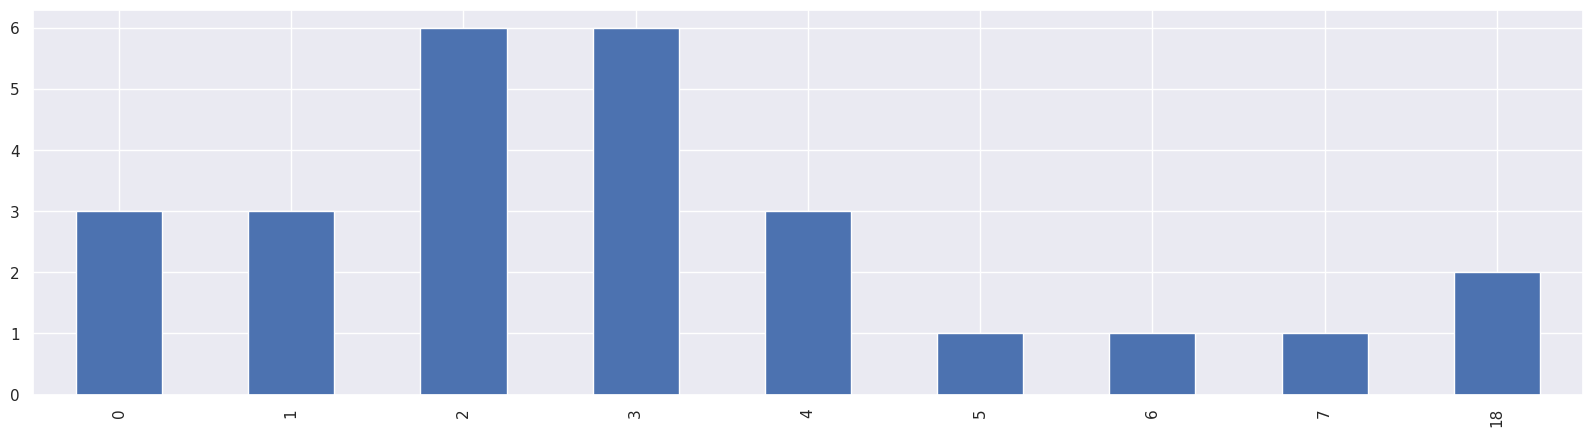

In [42]:
# For a given bar and a given instrument, we expect to see as number of trades between 0 and X,
# where X is the maximum number of child orders per bar.
bar_ccxt_order_aggregation[
    "order_count"
].stack().value_counts().sort_index().plot(kind="bar")

In [43]:
# Display order count by bar.
bar_ccxt_order_aggregation["order_count"]

asset_id,1464553467,1467591036
bar_end_datetime,,
2024-02-19 15:12:00+00:00,3,3
2024-02-19 15:21:00+00:00,3,6
2024-02-19 15:24:00+00:00,18,4
2024-02-19 15:27:00+00:00,4,0
2024-02-19 15:33:00+00:00,1,2
2024-02-19 15:36:00+00:00,2,2
2024-02-19 15:39:00+00:00,18,2
2024-02-19 15:42:00+00:00,4,0
2024-02-19 15:45:00+00:00,0,5


In [44]:
# If `buy_count` and `sell_count` are both greater than zero for an order,
#  it indicates a bug.
has_buys = ccxt_order_fills["buy_count"] > 0
has_sells = ccxt_order_fills["sell_count"] > 0
# This dataframe should have zero rows.
ccxt_order_fills.loc[has_buys & has_sells].shape[0]

0

In [45]:
# If `buy_count` and `sell_count` are both greater than zero for an instrument and bar,
#  there is likely a bar alignment or timing problem.
has_buys = bar_fills["buy_count"] > 0
has_sells = bar_fills["sell_count"] > 0
# This dataframe should be empty.
bar_fills.loc[has_buys & has_sells].shape[0]

0

In [46]:
# If `order_twap` and `order_vwap` are different for a given instrument and bar,
#  then we are likely submitting orders of differing sizes.
# Use rounding to ignore machine precision artifacts.
#
# If this number is not zero, then closely inspect the dataframe (without summing
# absolute values).
bar_ccxt_order_aggregation["buy_limit_twap"].subtract(
    bar_ccxt_order_aggregation["buy_limit_vwap"]
).abs().sum().sum().round(9)

0.000707317

In [47]:
# Analogous check but for sells.
bar_ccxt_order_aggregation["sell_limit_twap"].subtract(
    bar_ccxt_order_aggregation["sell_limit_vwap"]
).abs().sum().sum().round(9)

0.001512195

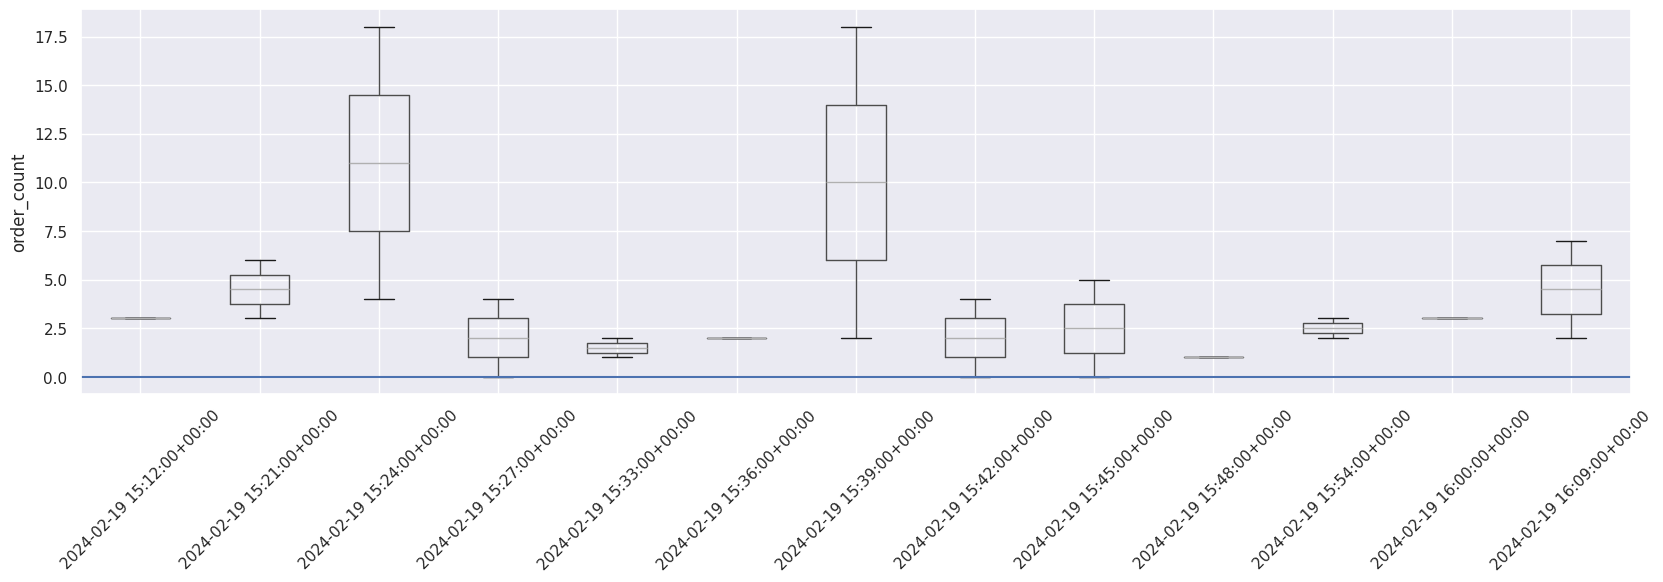

In [48]:
# Plot order counts by timestamp.
col = "order_count"
coplotti.plot_boxplot(bar_ccxt_order_aggregation[col], "by_row", ylabel=col)

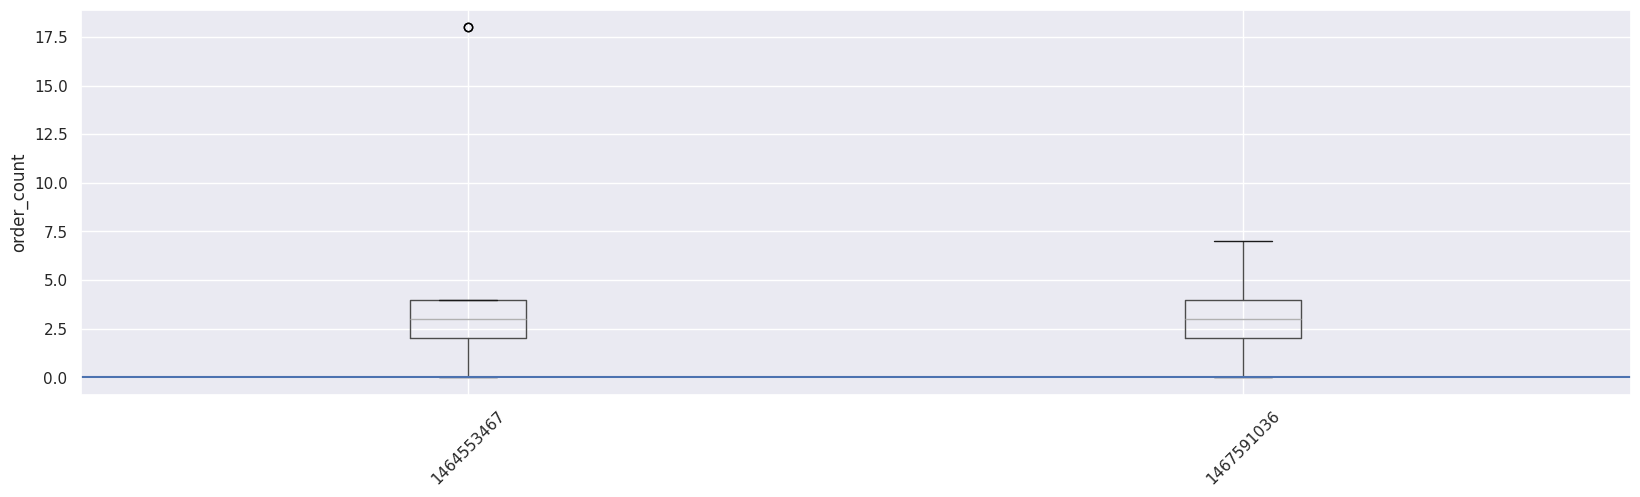

In [49]:
# Plot order counts by asset.
col = "order_count"
coplotti.plot_boxplot(bar_ccxt_order_aggregation[col], "by_col", ylabel=col)

# Fee summary

In [50]:
group_by_col = "is_buy"
obccexqu.generate_fee_summary(fills_df, "is_buy")

is_buy,False,True,combined
fill_count,13.000000,9.000000,22.000000
traded_volume_dollars,11272.115800,9782.790070,21054.905870
fill_fees_dollars,2.794495,3.293954,6.088449
fill_fees_bps,2.479122,3.367091,2.891701
realized_pnl_dollars,0.929750,-0.535280,0.394470
realized_pnl_bps,0.824823,-0.547165,0.187353
is_buy,0.000000,9.000000,9.000000
is_maker,12.000000,6.000000,18.000000
is_positive_realized_pnl,4.000000,3.000000,7.000000


In [51]:
group_by_col = "is_maker"
obccexqu.generate_fee_summary(fills_df, group_by_col)

is_maker,False,True,combined
fill_count,4.000000,18.000000,22.000000
traded_volume_dollars,6258.227460,14796.678410,21054.905870
fill_fees_dollars,3.129114,2.959336,6.088449
fill_fees_bps,5.000000,2.000000,2.891701
realized_pnl_dollars,2.496340,-2.101870,0.394470
realized_pnl_bps,3.988893,-1.420501,0.187353
is_buy,3.000000,6.000000,9.000000
is_maker,0.000000,18.000000,18.000000
is_positive_realized_pnl,3.000000,4.000000,7.000000


In [52]:
group_by_col = "is_positive_realized_pnl"
obccexqu.generate_fee_summary(fills_df, group_by_col)

is_positive_realized_pnl,False,True,combined
fill_count,15.000000,7.000000,22.000000
traded_volume_dollars,11544.518180,9510.387690,21054.905870
fill_fees_dollars,2.758429,3.330020,6.088449
fill_fees_bps,2.389384,3.501456,2.891701
realized_pnl_dollars,-5.817250,6.211720,0.394470
realized_pnl_bps,-5.038972,6.531511,0.187353
is_buy,6.000000,3.000000,9.000000
is_maker,14.000000,4.000000,18.000000
is_positive_realized_pnl,0.000000,7.000000,7.000000


In [53]:
group_by_col = "wave_id"
obccexqu.generate_fee_summary(fills_df, group_by_col)

wave_id,0,1,2,3,4,5,6,combined
fill_count,3.000000,6.000000,7.000000,3.000000,1.000000,1.000000,1.000000,22.000000
traded_volume_dollars,4758.174160,2673.869120,6297.472490,4454.056400,1147.792800,1462.728400,260.812500,21054.905870
fill_fees_dollars,1.839506,0.534774,1.709020,1.430883,0.229559,0.292546,0.052163,6.088449
fill_fees_bps,3.865991,2.000000,2.713819,3.212539,2.000000,2.000000,2.000000,2.891701
realized_pnl_dollars,1.532700,-0.997824,0.460620,1.646850,-1.263576,-0.984300,0.000000,0.394470
realized_pnl_bps,3.221194,-3.731759,0.731436,3.697416,-11.008751,-6.729206,0.000000,0.187353
is_buy,3.000000,4.000000,1.000000,0.000000,0.000000,1.000000,0.000000,9.000000
is_maker,1.000000,6.000000,6.000000,2.000000,1.000000,1.000000,1.000000,18.000000
is_positive_realized_pnl,3.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,7.000000


In [54]:
# Get by-wave summary for a single test asset.
test_fills = fills_df[fills_df["asset_id"] == test_asset_id]
group_by_col = "wave_id"
obccexqu.generate_fee_summary(test_fills, group_by_col)

wave_id,0,1,2,3,combined
fill_count,2.000000,3.000000,4.000000,2.000000,11.000000
traded_volume_dollars,3297.971360,896.259720,3898.253490,3303.298000,11395.782570
fill_fees_dollars,1.109404,0.179252,1.229176,1.200731,3.718564
fill_fees_bps,3.363899,2.000000,3.153146,3.634947,3.263105
realized_pnl_dollars,1.287400,-0.612000,0.667720,0.910950,2.254070
realized_pnl_bps,3.903612,-6.828378,1.712870,2.757699,1.977986
is_buy,2.000000,2.000000,1.000000,0.000000,5.000000
is_maker,1.000000,3.000000,3.000000,1.000000,8.000000
is_positive_realized_pnl,2.000000,0.000000,2.000000,1.000000,5.000000


# Time to fill ECDFs

<Axes: xlabel='secs_to_fill'>

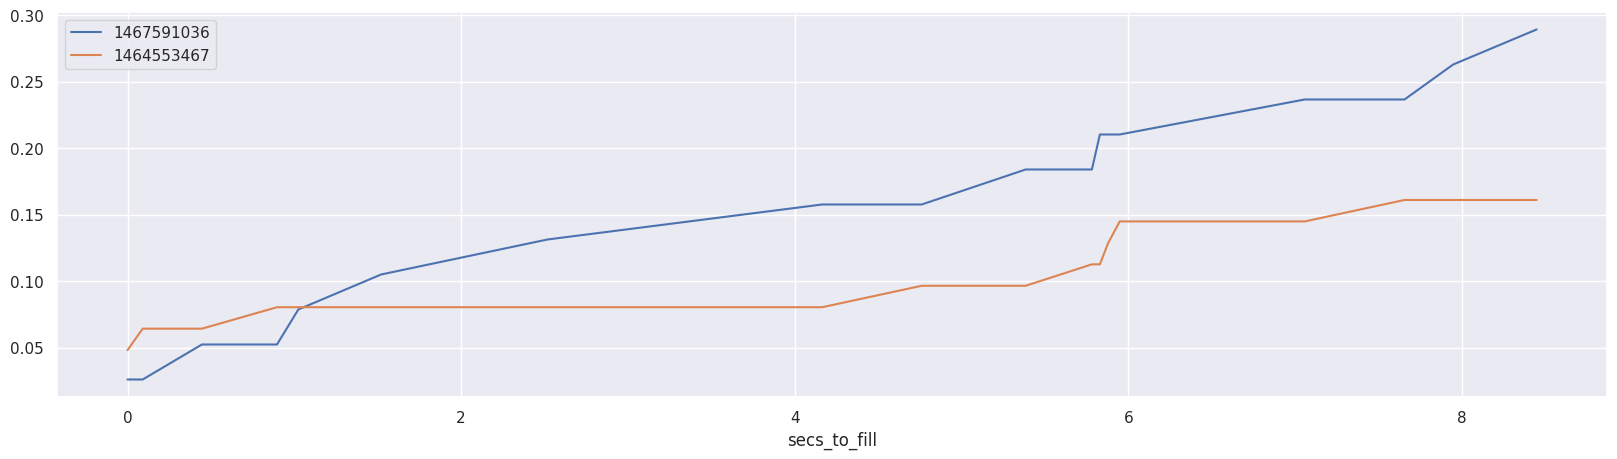

In [55]:
# Compute and plot time to fill ECDFs.
adj_fill_ecdfs = obccexqu.compute_adj_fill_ecdfs(
    fills_df, ccxt_order_response_df, child_order_df
)
adj_fill_ecdfs.plot()

INFO  All trades for wave_id=4 were conducted immediately (with rounding)
INFO  All trades for wave_id=5 were conducted immediately (with rounding)
INFO  All trades for wave_id=6 were conducted immediately (with rounding)
INFO  No trades found for wave id=7
INFO  No trades found for wave id=8
INFO  No trades found for wave id=9
INFO  No trades found for wave id=10
INFO  No trades found for wave id=11
INFO  No trades found for wave id=12
INFO  No trades found for wave id=13
INFO  No trades found for wave id=14
INFO  No trades found for wave id=15
INFO  No trades found for wave id=16
INFO  No trades found for wave id=17


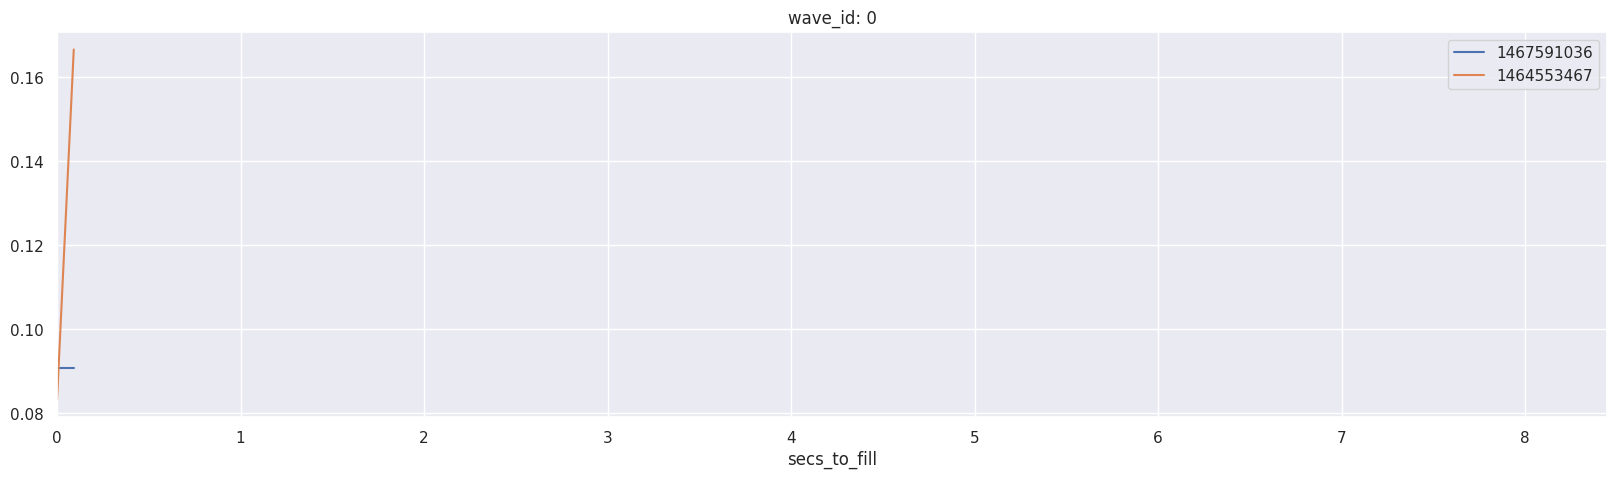

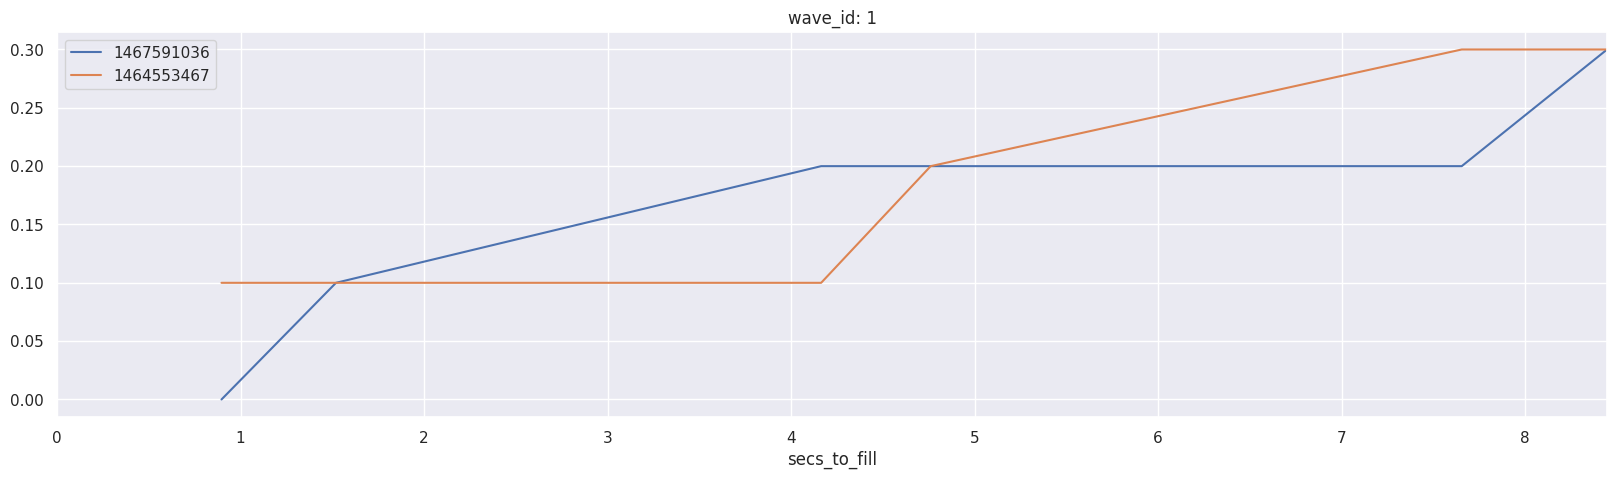

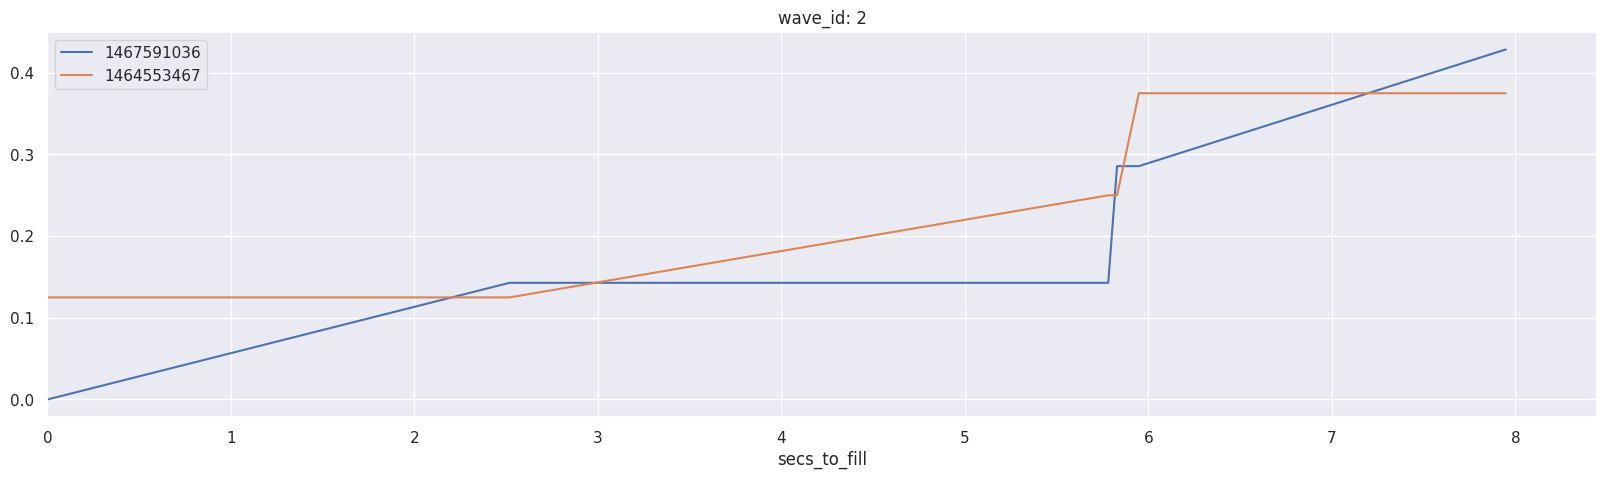

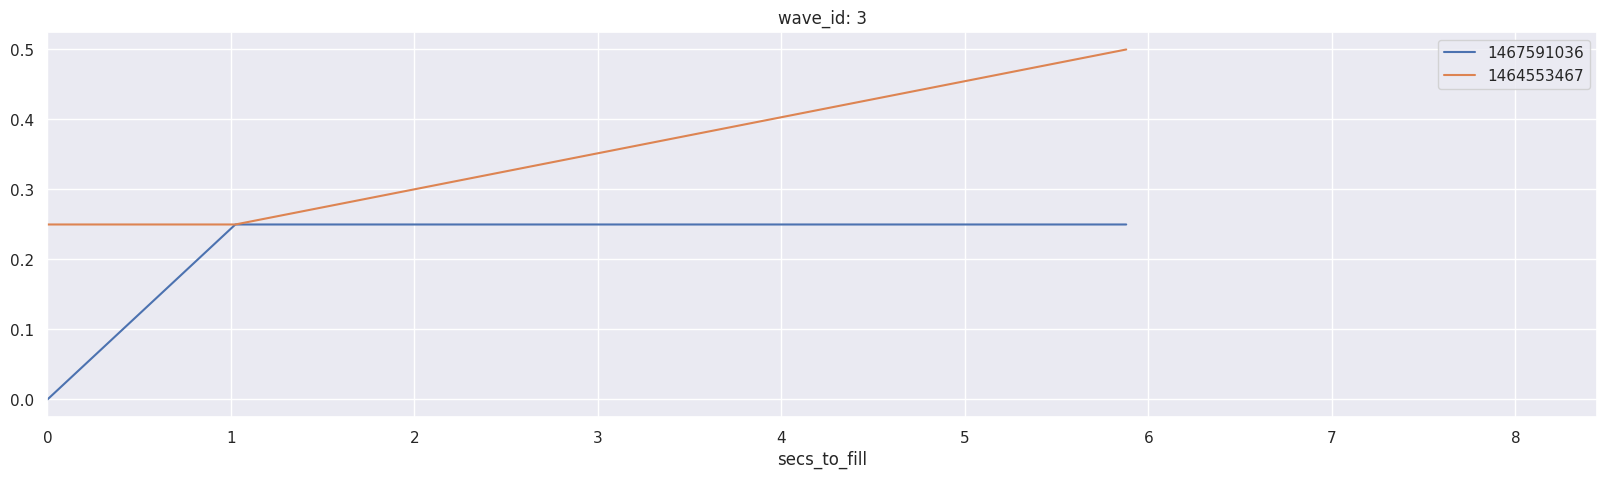

In [56]:
# Plot ECDFs by child order wave.
if "wave_id" in child_order_df.columns:
    cplexsta.plot_adj_fill_ecdfs(
        fills_df,
        ccxt_order_response_df,
        child_order_df,
    )

# Execution quality

## Compute `target_position_df` and `portfolio_df`

In [57]:
# TODO(Danya): add to config.
price_df = ohlcv_bars["close"]
target_position_df = oororcon.convert_order_df_to_target_position_df(
    parent_order_df,
    price_df,
)
hpandas.df_to_str(target_position_df, num_rows=5, log_level=logging.INFO)

holdings_notional            holdings_shares                 price            target_holdings_notional            target_holdings_shares            target_trades_notional            target_trades_shares           
                                 1464553467 1467591036      1464553467 1467591036 1464553467 1467591036               1464553467 1467591036             1464553467 1467591036             1464553467 1467591036           1464553467 1467591036
2024-02-19 15:09:00+00:00               0.0        0.0             0.0        0.0    2905.98    52179.0               -598.63188   -887.043                 -0.206     -0.017             -598.63188   -887.043               -0.206     -0.017
2024-02-19 15:12:00+00:00        -599.03564     -887.4          -0.206     -0.017    2907.94    52200.0               -613.57534     -887.4                 -0.211     -0.017               -14.5397        0.0               -0.005        0.0
                                        ...        ...             ...        ...        ...        ...                      ...        ...                    ...        ...                    ...        ...                  ...        ...
2024-02-19 16:03:00+00:00        -899.04786  -625.7292          -0.309     -0.012    2909.54    52144.1               -899.04786  -625.7292                 -0.309     -0.012                    0.0        0.0                  0.0        0.0
2024-02-19 16:06:00+00:00          -900.426   -626.442          -0.309     -0.012     2914.0    52203.5                 -600.284  -887.4595                 -0.206     -0.017                300.142  -261.0175                0.103     -0.005

In [58]:
portfolio_df = obccexqu.convert_bar_fills_to_portfolio_df(
    bar_fills,
    price_df,
)
hpandas.df_to_str(portfolio_df, num_rows=5, log_level=logging.INFO)

holdings_shares            holdings_notional            executed_trades_shares            executed_trades_notional                   pnl           
asset_id                       1464553467 1467591036        1464553467 1467591036             1464553467 1467591036               1464553467 1467591036 1464553467 1467591036
2024-02-19 15:09:00+00:00             NaN        NaN               NaN        NaN                    NaN        NaN                      NaN        NaN        NaN        NaN
2024-02-19 15:12:00+00:00          -0.206     -0.017        -599.03564     -887.4                 -0.206     -0.017               -598.61952  -887.1008   -0.41612    -0.2992
                                      ...        ...               ...        ...                    ...        ...                      ...        ...        ...        ...
2024-02-19 16:09:00+00:00          -0.207     -0.017        -602.66187   -886.312                  0.102     -0.005                297.13926  -260.8125    0.62487     0.9425
2024-02-19 16:12:00+00:00             NaN        NaN               NaN        NaN                    NaN        NaN                      NaN        NaN        NaN        NaN

## PNL and price for the test asset

<Axes: >

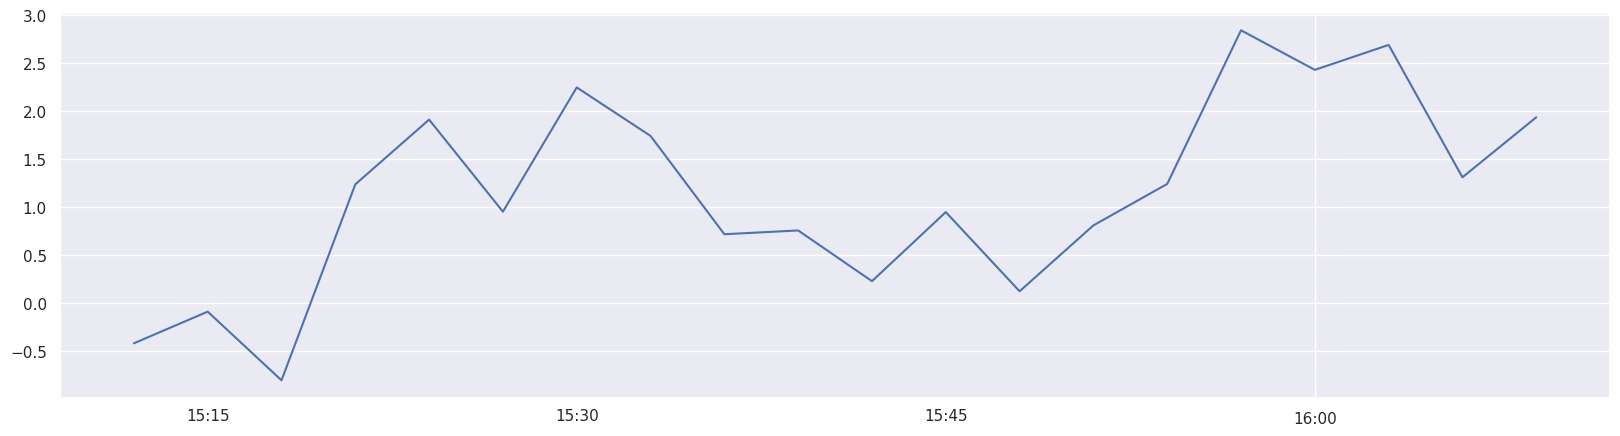

In [59]:
portfolio_df["pnl"][test_asset_id].cumsum().plot()

<Axes: xlabel='end_timestamp'>

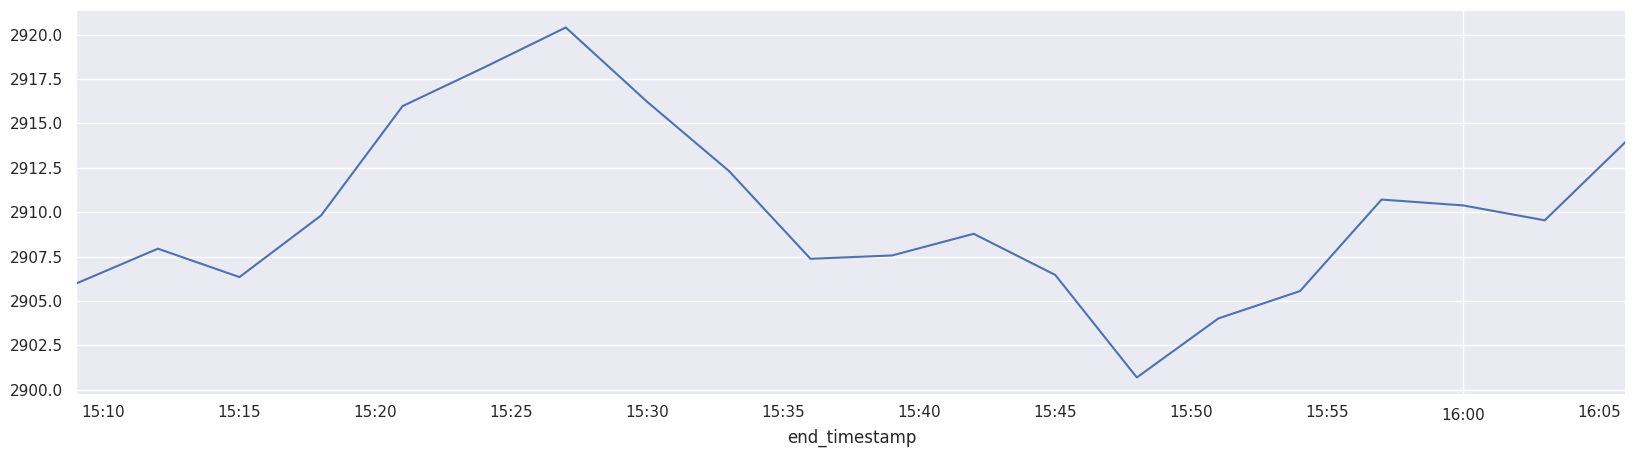

In [60]:
target_position_df["price"][test_asset_id].plot()

## Compute execution quality

In [61]:
(
    execution_quality_df,
    execution_quality_stats_df,
) = cftpdp.compute_execution_quality_df(
    portfolio_df,
    target_position_df,
)
hpandas.df_to_str(execution_quality_df, num_rows=5, log_level=logging.INFO)
hpandas.df_to_str(execution_quality_stats_df, num_rows=5, log_level=logging.INFO)

executed_trades_shares             fill_rate            underfill_share_count            underfill_notional            underfill_opportunity_cost_realized_notional            underfill_opportunity_cost_notional            tracking_error_shares            tracking_error_notional            tracking_error_bps                is_buy               is_sell            is_benchmark_profitable            holdings_price_per_share            trade_price_per_share            slippage_notional            slippage_notional_per_share            slippage_in_bps            benchmark_return_notional            benchmark_return_in_bps           
                                      1464553467 1467591036 1464553467 1467591036            1464553467 1467591036         1464553467 1467591036                                   1464553467 1467591036                          1464553467 1467591036            1464553467 1467591036              1464553467 1467591036         1464553467 1467591036 1464553467 1467591036 1464553467 1467591036              1464553467 1467591036               1464553467 1467591036            1464553467 1467591036        1464553467 1467591036                  1464553467 1467591036      1464553467 1467591036                1464553467 1467591036              1464553467 1467591036
2024-02-19 15:09:00+00:00                    0.0        0.0        NaN        NaN                   NaN        NaN                NaN        NaN                                          NaN        NaN                                 NaN        NaN                   NaN        NaN                     NaN        NaN                NaN        NaN      False      False      False      False                     0.0        0.0                  2905.98    52179.0                   NaN        NaN               NaN        NaN                         NaN        NaN             NaN        NaN                       0.0        0.0                     0.0        0.0
2024-02-19 15:12:00+00:00                 -0.206     -0.017        1.0        1.0                   0.0        0.0                0.0        0.0                                          NaN        NaN                                 0.0        0.0                   0.0        0.0                -0.40376     -0.357           6.744713   4.024608      False      False       True       True                     1.0        1.0                  2907.94    52200.0               2905.92    52182.4           0.41612     0.2992                        2.02       17.6        6.946498   3.371648                       1.6       26.3                5.502177   5.038314
                                             ...        ...        ...        ...                   ...        ...                ...        ...                                          ...        ...                                 ...        ...                   ...        ...                     ...        ...                ...        ...        ...        ...        ...        ...                     ...        ...                      ...        ...                   ...        ...               ...        ...                         ...        ...             ...        ...                       ...        ...                     ...        ...
2024-02-19 16:09:00+00:00                    NaN        NaN        NaN        NaN                   NaN        NaN                NaN        NaN                                          NaN        NaN                                 NaN        NaN                   NaN        NaN                     NaN        NaN                NaN        NaN        NaN        NaN        NaN        NaN                     NaN        NaN                      NaN        NaN               2913.13    52162.5               NaN        NaN                         NaN        NaN             NaN        NaN                       NaN        NaN                     NaN        NaN
2024-02-19 16:12:00+00:00                    NaN        NaN 

,slippage_notional,underfill_opportunity_cost_realized_notional,pnl,gross_volume,net_volume,gmv,nmv
2024-02-19 15:09:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-02-19 15:12:00+00:00,0.71532,NaN,-0.71532,1485.72032,-1485.72032,1486.43564,-1486.43564
,...,...,...,...,...,...,...
2024-02-19 16:09:00+00:00,NaN,NaN,1.56737,557.95176,36.32676,1488.97387,-1488.97387
2024-02-19 16:12:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
execution_quality_df.columns.levels[0].to_list()

['benchmark_return_in_bps',
 'benchmark_return_notional',
 'executed_trades_shares',
 'fill_rate',
 'holdings_price_per_share',
 'is_benchmark_profitable',
 'is_buy',
 'is_sell',
 'slippage_in_bps',
 'slippage_notional',
 'slippage_notional_per_share',
 'tracking_error_bps',
 'tracking_error_notional',
 'tracking_error_shares',
 'trade_price_per_share',
 'underfill_notional',
 'underfill_opportunity_cost_notional',
 'underfill_opportunity_cost_realized_notional',
 'underfill_share_count']

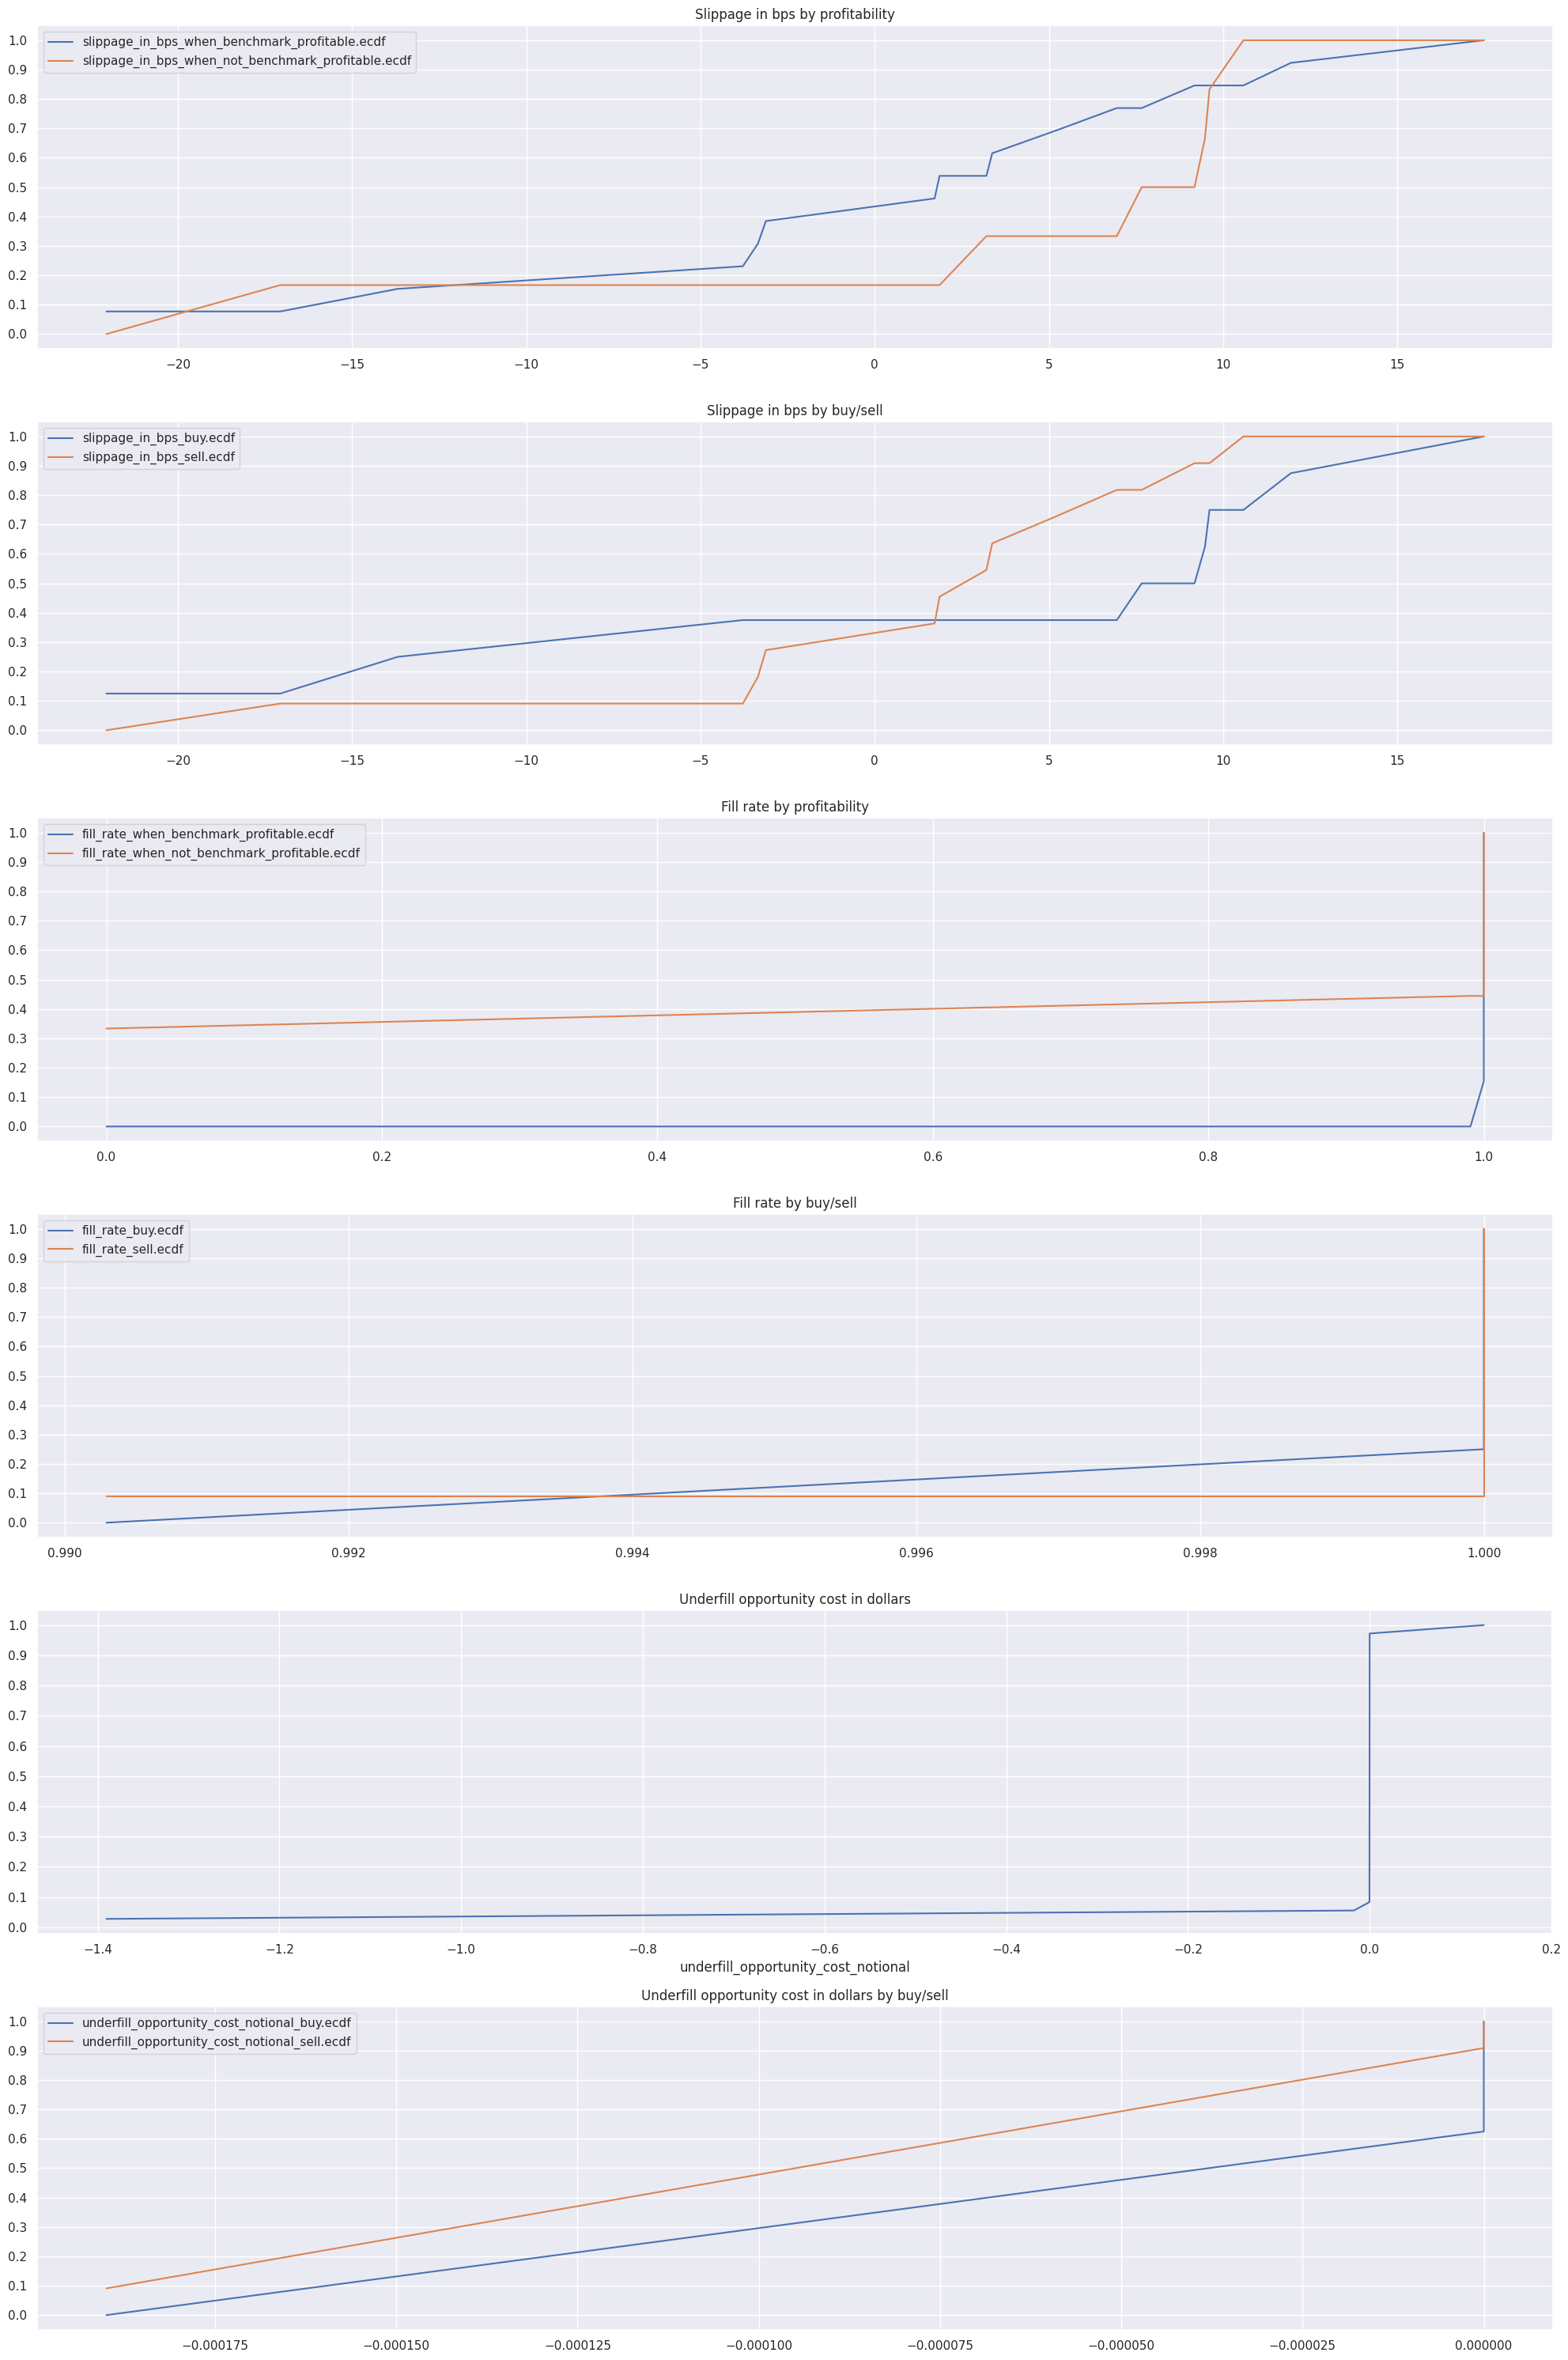

In [63]:
coplotti.plot_execution_ecdfs(execution_quality_df)

## Compute and plot portfolio stats

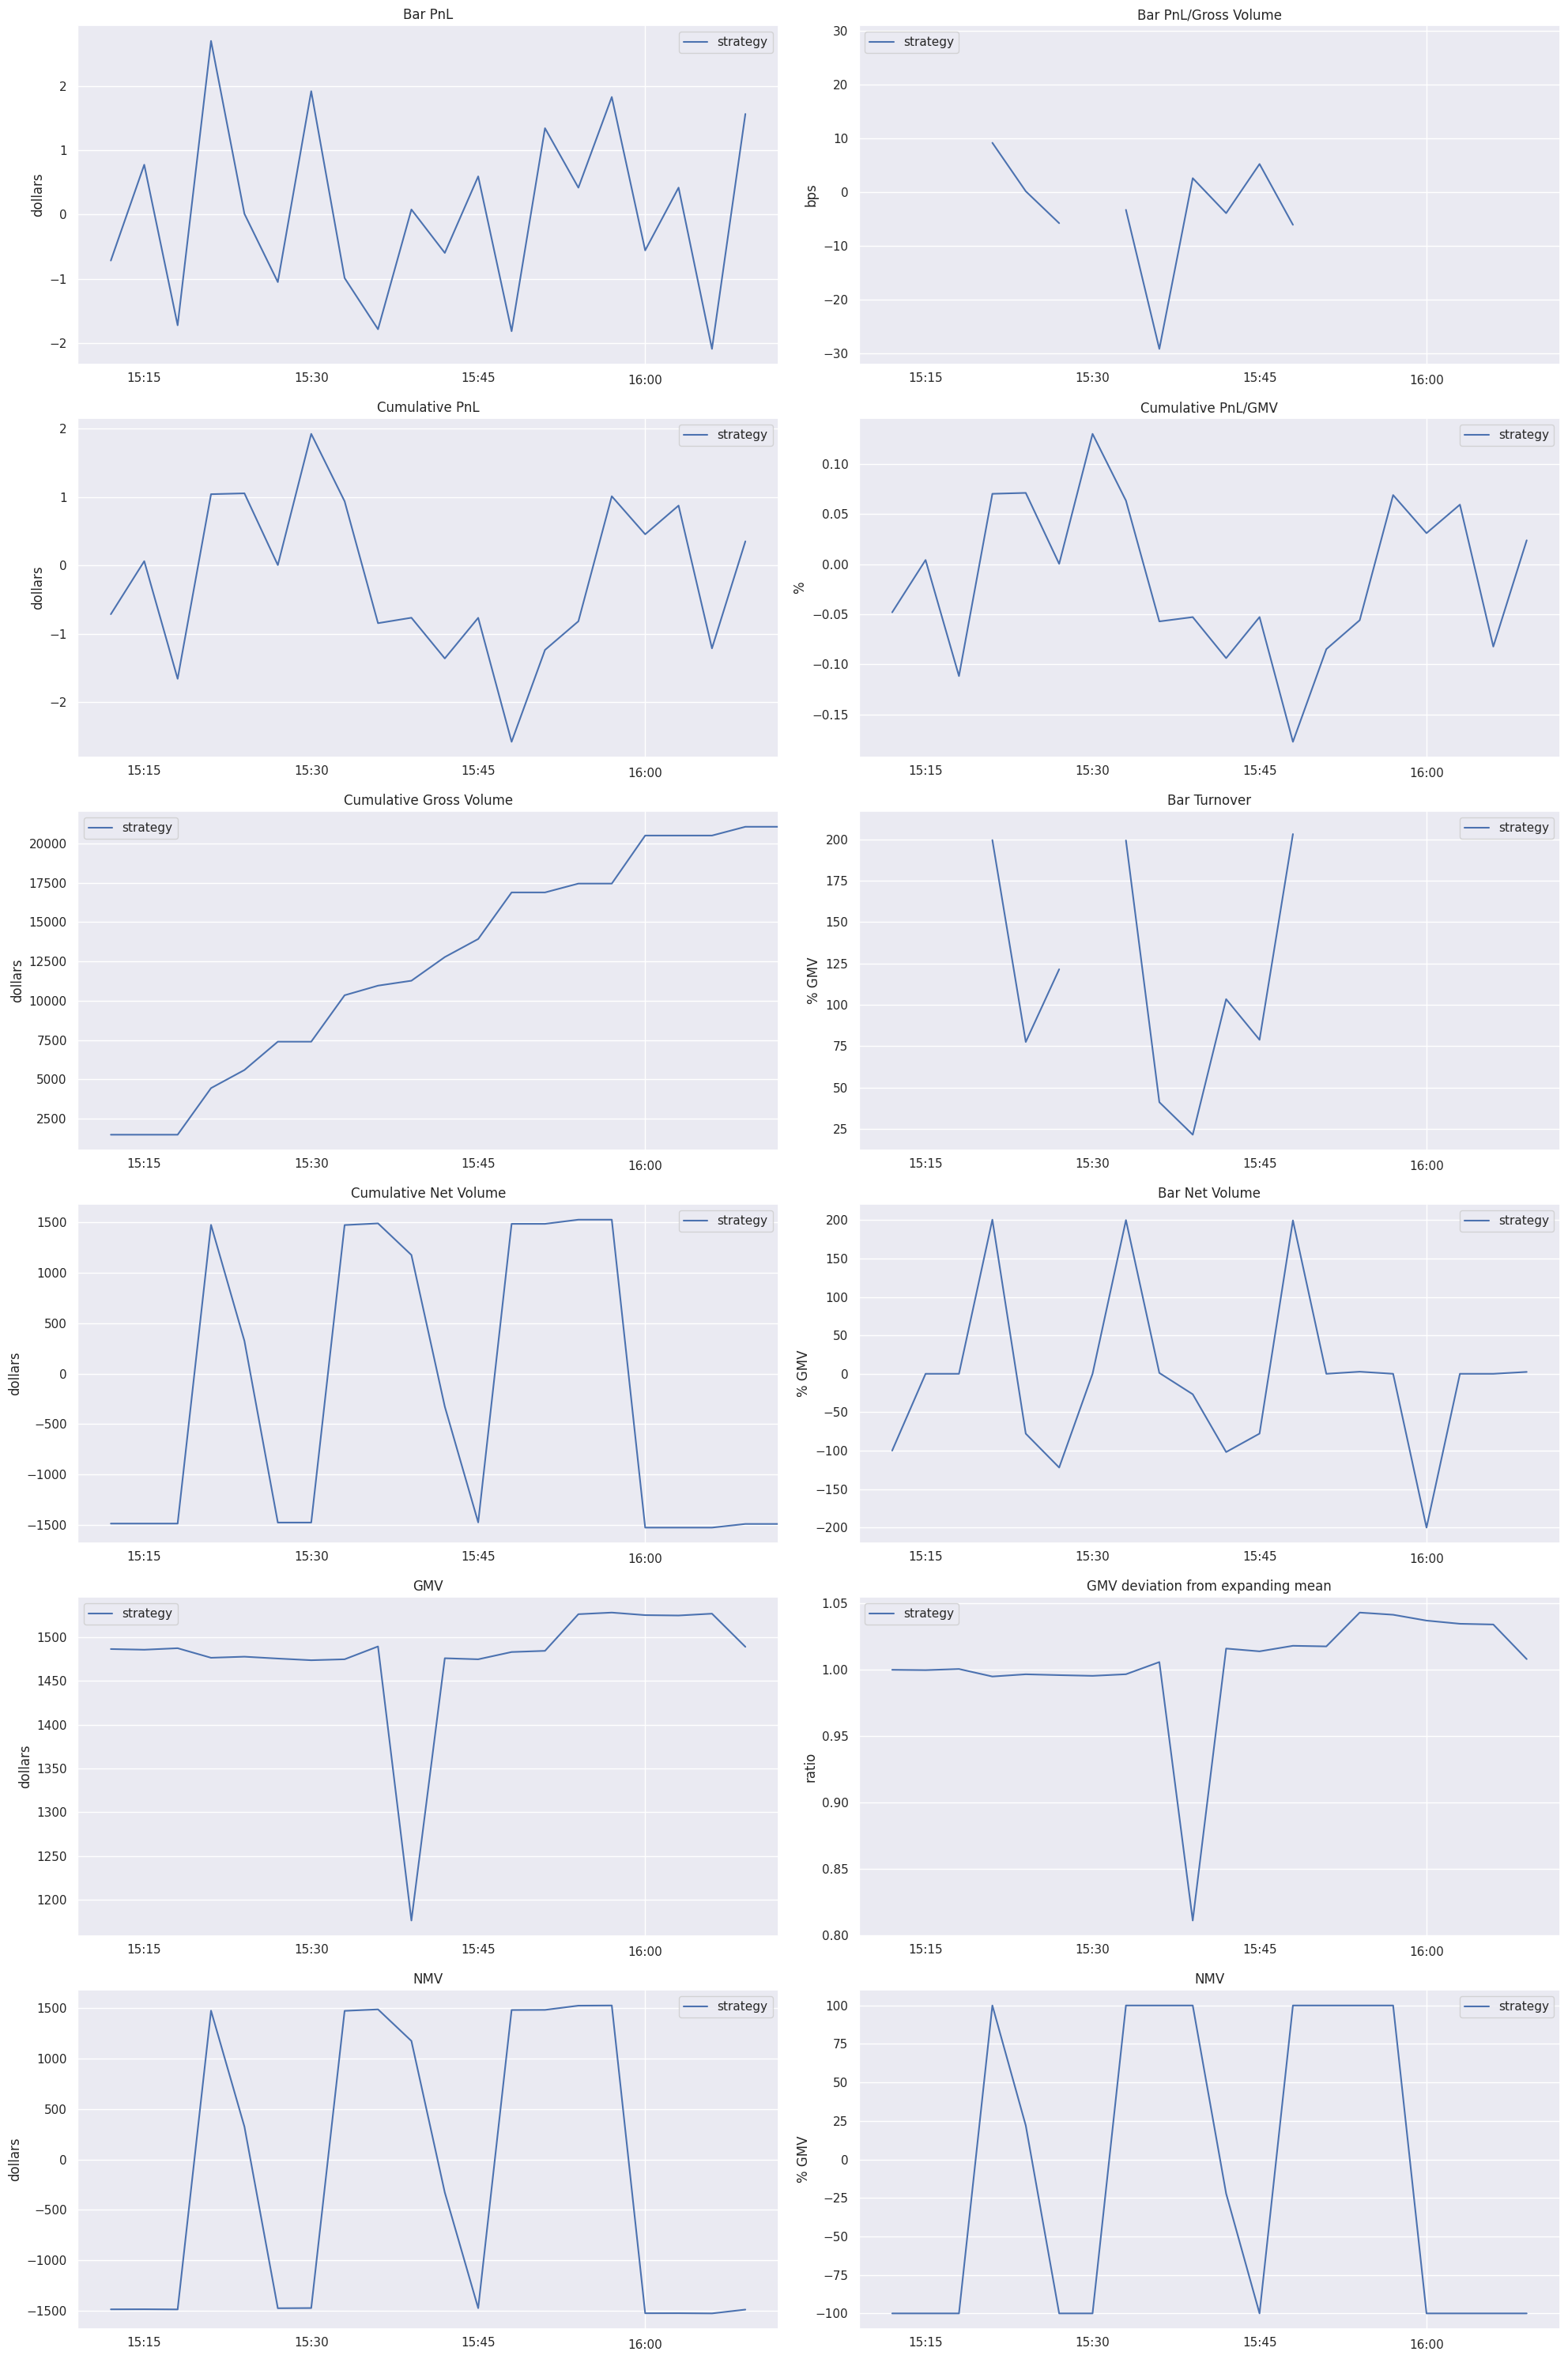

In [64]:
coplotti.plot_portfolio_stats(execution_quality_stats_df)

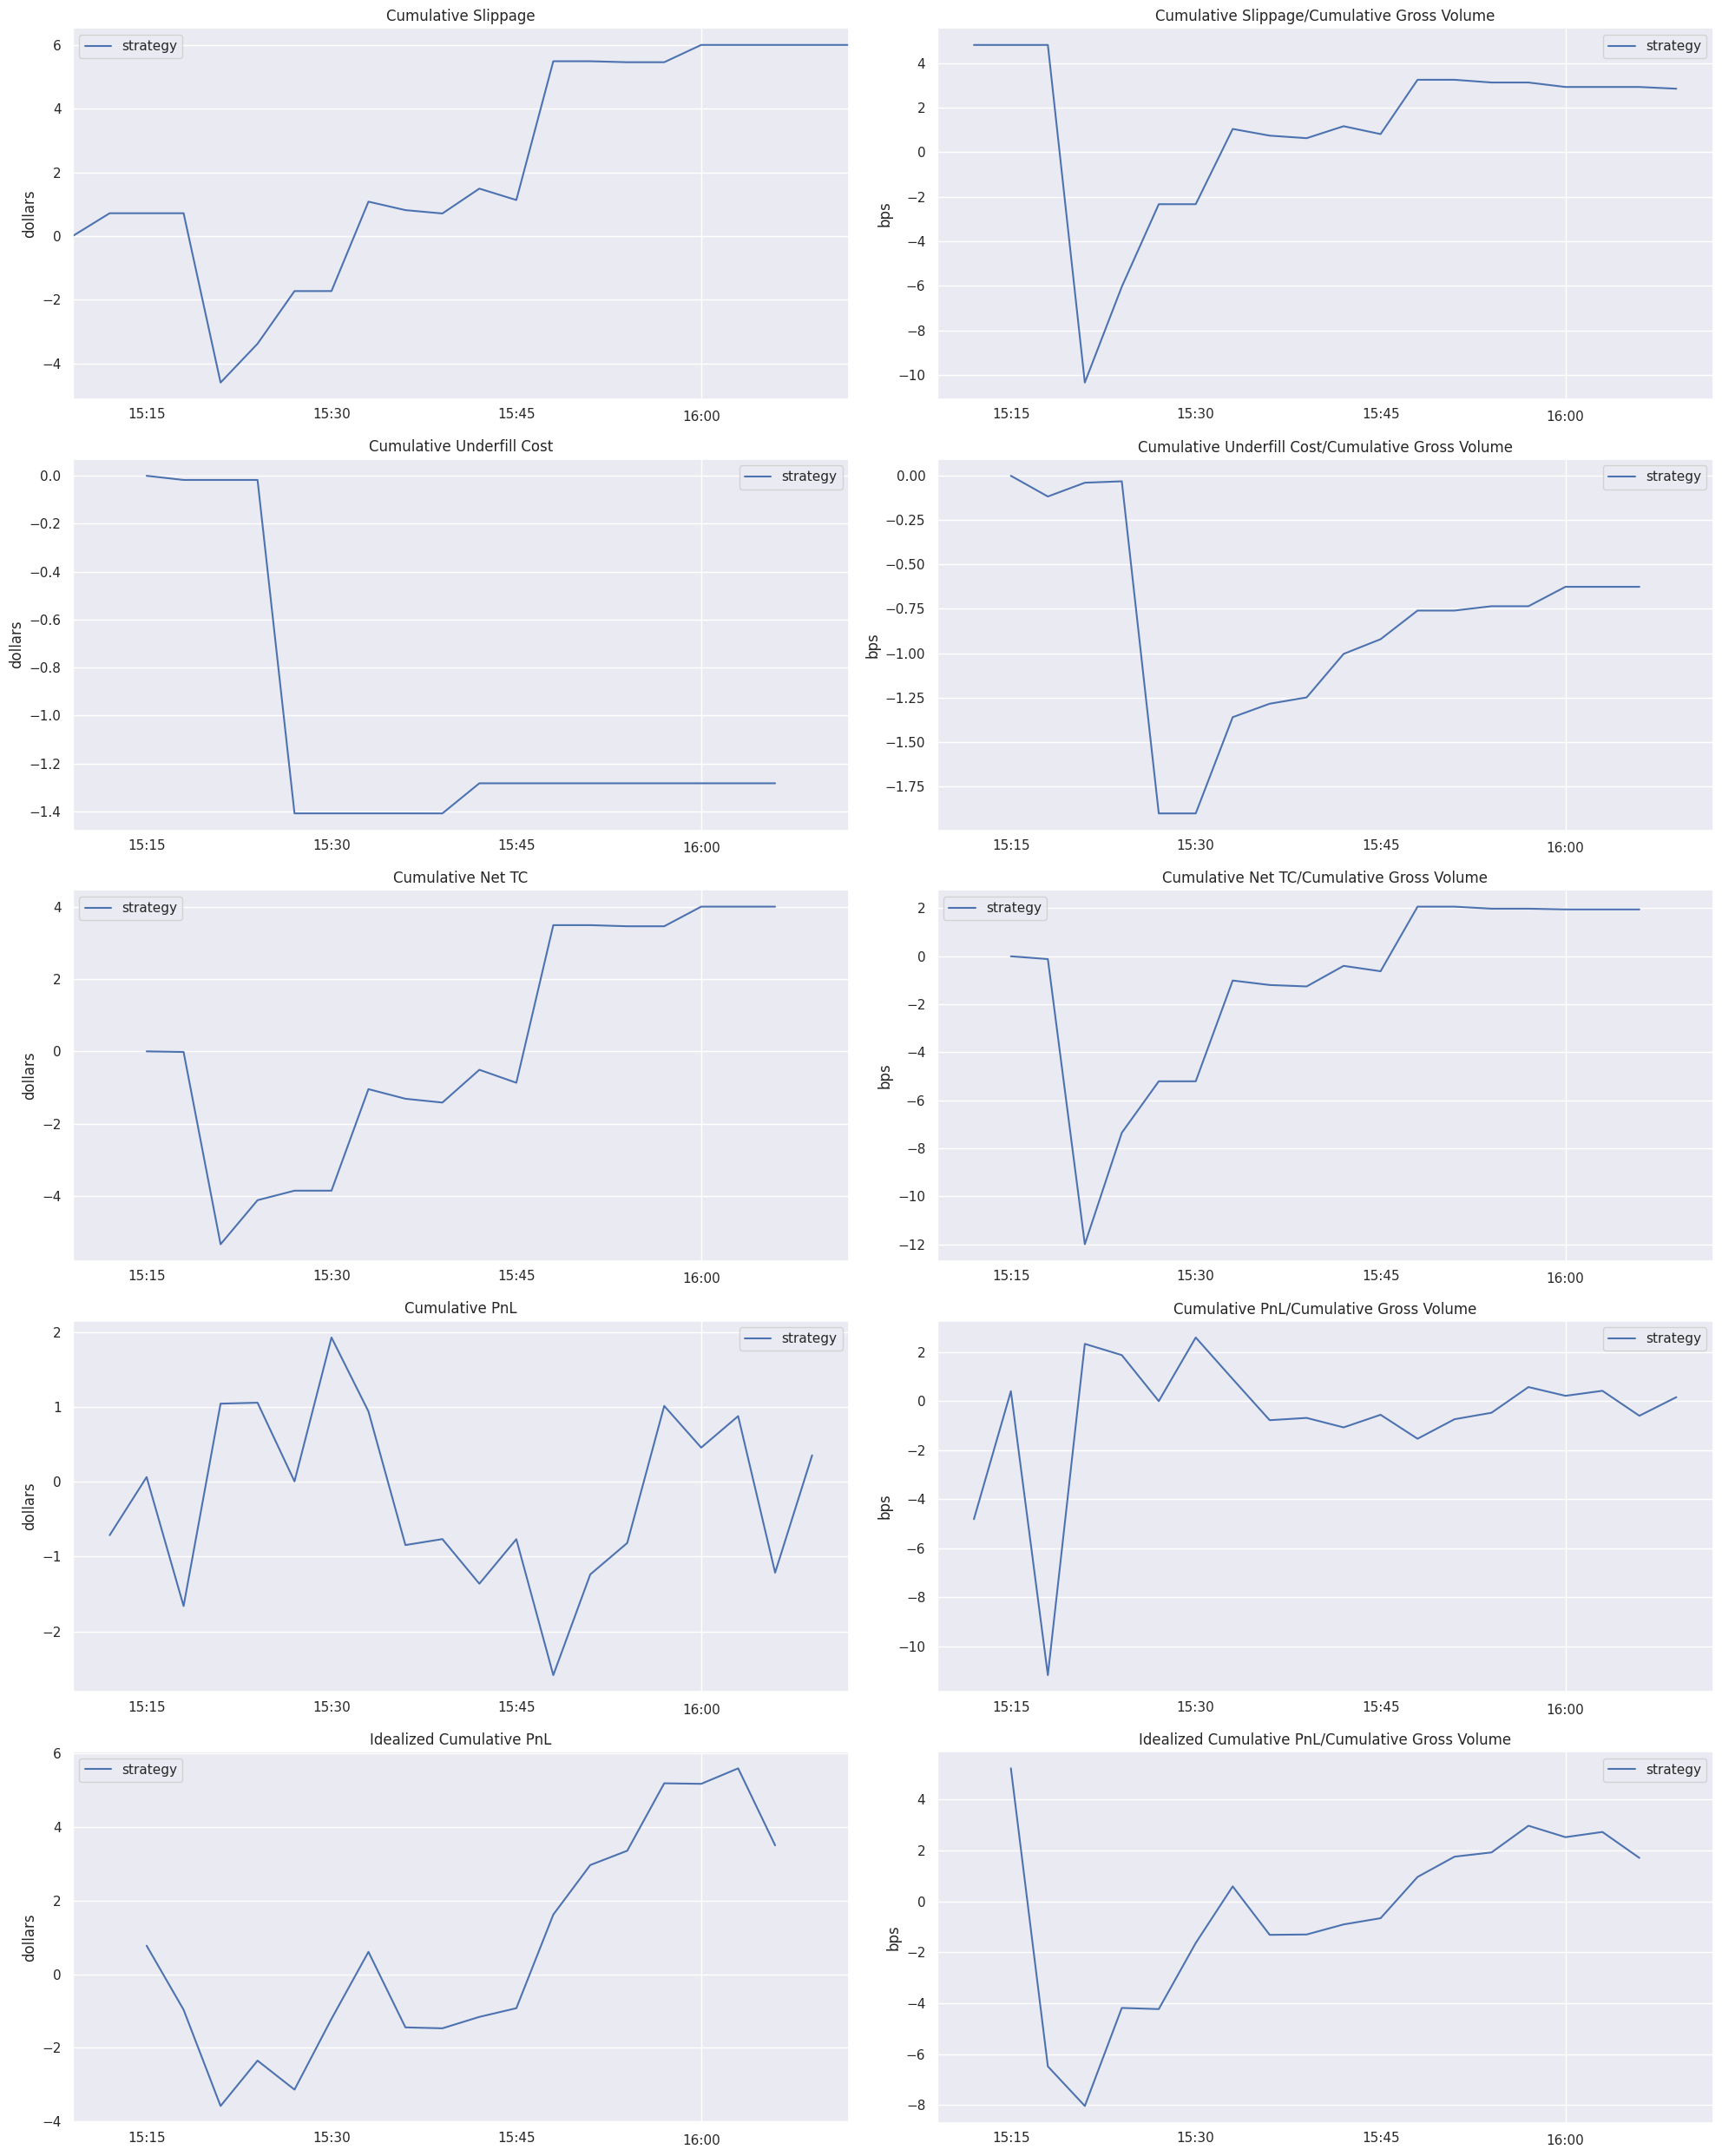

In [65]:
coplotti.plot_execution_stats(execution_quality_stats_df)

##  Filled order execution quality

In [66]:
filled_order_execution_quality = obccexqu.compute_filled_order_execution_quality(
    filled_ccxt_orders, tick_decimals=6
)
filled_order_execution_quality.head()

,direction,price_improvement_notional,price_improvement_bps,underfill_quantity,underfill_pct,underfill_notional_at_limit_price,underfill_notional_at_transaction_price
order,,,,,,,
8389765653579017173,-1,0.00,0.000000,0.0,0.0,0.0,0.0
8389765653580776865,1,0.03,0.103108,0.0,0.0,0.0,0.0
8389765653582385100,-1,0.30,1.028302,0.0,0.0,0.0,0.0
8389765653583706336,1,0.00,0.000000,0.0,0.0,0.0,0.0
8389765653584571890,-1,0.00,0.000000,0.0,0.0,0.0,0.0


In [67]:
# If any value is negative (up to machine precision), except for `direction`, it indicates a bug.
filled_order_execution_quality.loc[
    (filled_order_execution_quality.drop("direction", axis=1).round(9) < 0).any(
        axis=1
    )
].shape[0]

0

In [68]:
filled_order_execution_quality.min()

direction                                 -1.0
price_improvement_notional                 0.0
price_improvement_bps                      0.0
underfill_quantity                         0.0
underfill_pct                              0.0
underfill_notional_at_limit_price          0.0
underfill_notional_at_transaction_price    0.0
dtype: float64

In [69]:
filled_order_execution_quality.max()

direction                                  1.000000
price_improvement_notional                 0.300000
price_improvement_bps                      1.028302
underfill_quantity                         0.000000
underfill_pct                              0.000000
underfill_notional_at_limit_price          0.000000
underfill_notional_at_transaction_price    0.000000
dtype: float64

## Compare bar trade prices to OHLCV TWAP

In [70]:
actual_and_ohlcv_price_df = {
    "buy_trade_price": trade_prices["buy_trade_price"],
    "sell_trade_price": trade_prices["sell_trade_price"],
    "twap": ohlcv_bars["twap"],
    "high": ohlcv_bars["high"],
    "low": ohlcv_bars["low"],
}
actual_and_ohlcv_price_df = pd.concat(actual_and_ohlcv_price_df, axis=1)
hpandas.df_to_str(actual_and_ohlcv_price_df, num_rows=5, log_level=logging.INFO)

buy_trade_price            sell_trade_price                    twap                     high                   low           
asset_id                       1464553467 1467591036       1464553467 1467591036   1464553467    1467591036 1464553467 1467591036 1464553467 1467591036
2024-02-19 15:09:00+00:00             NaN        NaN              NaN        NaN  2905.943333  52187.866667    2907.98    52230.5    2904.48    52170.3
2024-02-19 15:12:00+00:00             NaN        NaN          2905.92    52182.4  2907.606667  52196.466667    2908.87    52213.4    2905.28    52178.1
                                      ...        ...              ...        ...          ...           ...        ...        ...        ...        ...
2024-02-19 16:09:00+00:00         2913.13        NaN              NaN    52162.5      2911.74       52154.0     2914.0    52203.5    2910.87    52136.0
2024-02-19 16:12:00+00:00             NaN        NaN              NaN        NaN      2911.84       52136.6    2912.46    52147.8    2910.58    52130.4

In [71]:
actual_vs_ohlcv_execution_df = cofinanc.compute_ref_price_execution_quality(
    actual_and_ohlcv_price_df,
    "twap",
    "twap",
    "buy_trade_price",
    "sell_trade_price",
)
hpandas.df_to_str(
    actual_vs_ohlcv_execution_df, num_rows=5, log_level=logging.INFO
)

buy_trade_slippage_notional            buy_trade_slippage_bps            sell_trade_slippage_notional            sell_trade_slippage_bps           
asset_id                                   1464553467 1467591036             1464553467 1467591036                   1464553467 1467591036              1464553467 1467591036
2024-02-19 15:09:00+00:00                         NaN        NaN                    NaN        NaN                          NaN        NaN                     NaN        NaN
2024-02-19 15:12:00+00:00                         NaN        NaN                    NaN        NaN                     1.686667  14.066667                5.800876   2.694946
                                                  ...        ...                    ...        ...                          ...        ...                     ...        ...
2024-02-19 16:09:00+00:00                        1.39        NaN               4.773778        NaN                          NaN       -8.5                     NaN  -1.629789
2024-02-19 16:12:00+00:00                         NaN        NaN                    NaN        NaN                          NaN        NaN                     NaN        NaN

In [72]:
actual_vs_ohlcv_execution_df.columns.levels[0].to_list()

['buy_trade_slippage_notional',
 'buy_trade_slippage_bps',
 'sell_trade_slippage_notional',
 'sell_trade_slippage_bps']

<Axes: >

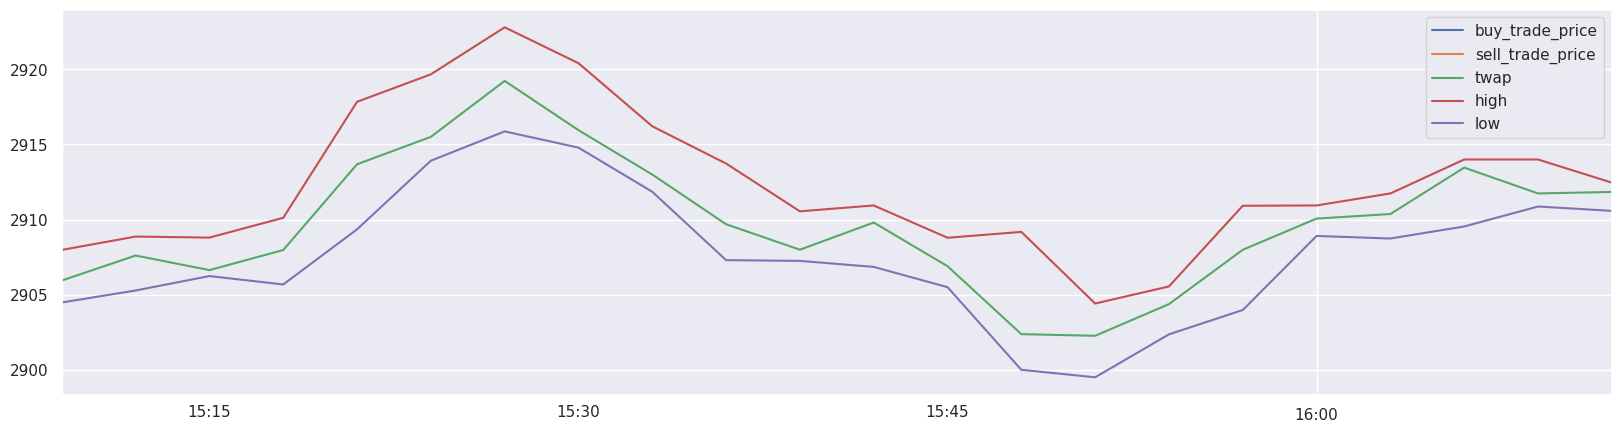

In [73]:
cofinanc.get_asset_slice(actual_and_ohlcv_price_df, test_asset_id).plot()

## Spread and High-Low Range

### Average bid/ask spread by asset_id

In [74]:
# Display average notional spread per instrument.
average_spread_notional = child_order_df.groupby("asset_id")["spread"].mean()
average_spread_notional

asset_id
1464553467    0.01
1467591036    0.10
Name: spread, dtype: float64

In [75]:
child_order_df.head()

,creation_timestamp,asset_id,type_,start_timestamp,end_timestamp,curr_num_shares,diff_num_shares,tz,extra_params,volatility_multiple,wave_id,num_data_points,exchange_timestamp,knowledge_timestamp,end_download_timestamp,latest_bid_size,latest_ask_size,num_data_points_resampled,scaling_multiplier,bid_vol,bid_vol_bps,latest_bid_price,ask_vol,ask_vol_bps,latest_ask_price,total_vol,latest_mid_price,total_vol_bps,spread,spread_bps,total_vol_to_spread_bps,limit_price,ccxt_id,name,attempt_num
order_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3,2024-02-19 15:09:05.307975+00:00,1464553467,limit,2024-02-19 15:09:05.307975+00:00,2024-02-19 15:09:10+00:00,0.000,-0.206,America/New_York,{'stats': {'_submit_twap_child_order::wave_id'...,1.5,0,289,2024-02-19 15:09:04.730000+00:00,2024-02-19 15:09:04.848809+00:00,2024-02-19 15:09:04.826719+00:00,87.550,110.968,598,10.0,0.466068,1.603819,2905.99,0.467002,1.607025,2906.00,0.466535,2905.995,1.605423,0.01,0.034412,46.653504,2906.69,8389765653578981373,3,1
5,2024-02-19 15:09:10.226783+00:00,1464553467,limit,2024-02-19 15:09:10.226783+00:00,2024-02-19 15:09:20+00:00,0.000,-0.206,America/New_York,{'stats': {'_submit_twap_child_order::wave_id'...,0.7,1,288,2024-02-19 15:09:09.704000+00:00,2024-02-19 15:09:09.794508+00:00,2024-02-19 15:09:09.779835+00:00,36.281,105.437,597,10.0,0.377625,1.299471,2905.99,0.378779,1.303436,2906.00,0.378202,2905.995,1.301455,0.01,0.034412,37.820221,2906.25,8389765653578987144,5,1
7,2024-02-19 15:09:20.186431+00:00,1464553467,limit,2024-02-19 15:09:20.186431+00:00,2024-02-19 15:09:30+00:00,0.000,-0.206,America/New_York,{'stats': {'_submit_twap_child_order::wave_id'...,0.7,2,289,2024-02-19 15:09:19.688000+00:00,2024-02-19 15:09:19.724792+00:00,2024-02-19 15:09:19.707217+00:00,16.870,34.296,598,10.0,0.374233,1.287945,2905.66,0.375395,1.291939,2905.67,0.374814,2905.665,1.289943,0.01,0.034416,37.481430,2905.92,8389765653579017173,7,1
9,2024-02-19 15:12:04.804581+00:00,1464553467,limit,2024-02-19 15:12:04.804581+00:00,2024-02-19 15:12:10+00:00,-0.206,-0.005,America/New_York,{'stats': {'_submit_twap_child_order::wave_id'...,1.5,0,288,2024-02-19 15:12:04.284000+00:00,2024-02-19 15:12:04.379907+00:00,2024-02-19 15:12:04.362181+00:00,43.743,15.419,597,10.0,0.476811,1.639693,2907.93,0.476318,1.637992,2907.94,0.476565,2907.935,1.638843,0.01,0.034389,47.656489,2908.64,-1,9,1
10,2024-02-19 15:12:10.160676+00:00,1464553467,limit,2024-02-19 15:12:10.160676+00:00,2024-02-19 15:12:20+00:00,-0.206,-0.005,America/New_York,{'stats': {'_submit_twap_child_order::wave_id'...,0.7,1,288,2024-02-19 15:12:09.726000+00:00,2024-02-19 15:12:09.759559+00:00,2024-02-19 15:12:09.745068+00:00,30.358,22.494,598,10.0,0.459808,1.581222,2907.93,0.459298,1.579462,2907.94,0.459553,2907.935,1.580343,0.01,0.034389,45.955335,2908.25,-1,10,1


In [76]:
# Display average spread per instrument in bps.
average_spread_bps = (
    child_order_df.groupby("asset_id")["spread_bps"].mean().sort_values()
)
average_spread_bps

asset_id
1467591036    0.019155
1464553467    0.034360
Name: spread_bps, dtype: float64

<Axes: title={'center': 'Average Spread per Instrument in Basis Points'}, xlabel='Instrument', ylabel='Average Spread (bps)'>

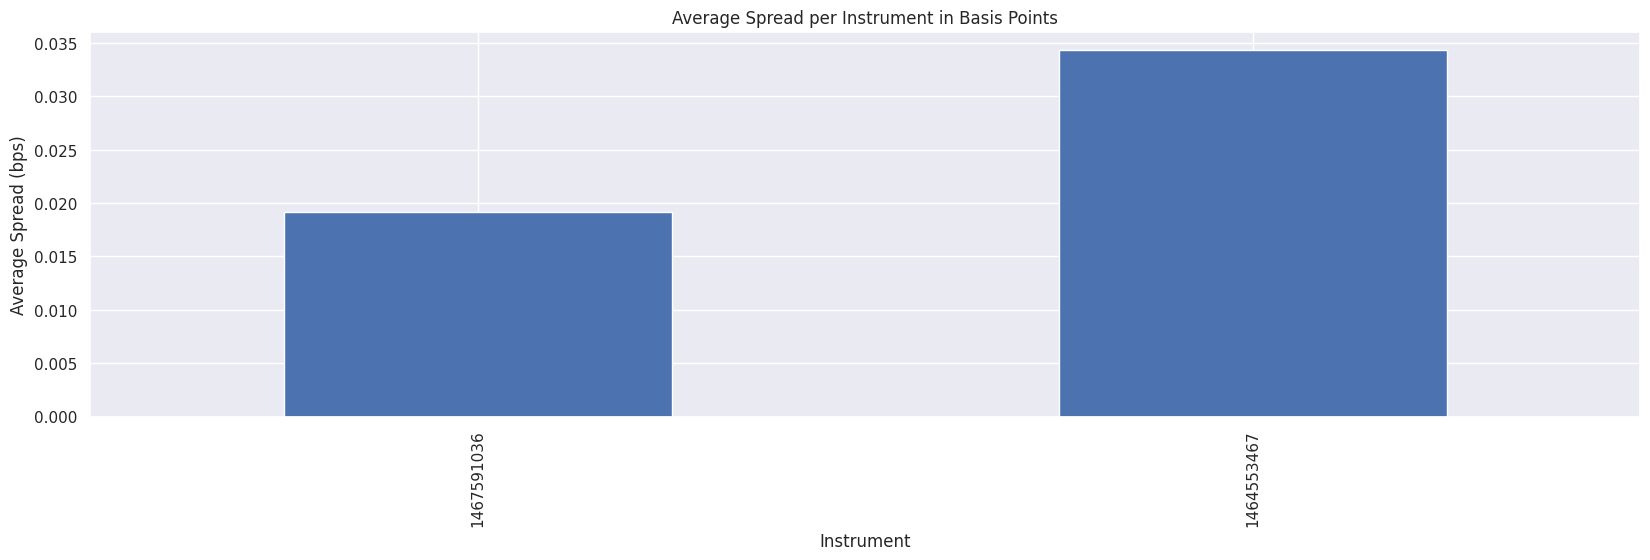

In [77]:
average_spread_bps.plot(
    kind="bar",
    title="Average Spread per Instrument in Basis Points",
    xlabel="Instrument",
    ylabel="Average Spread (bps)",
)

### OHLCV high-low spread to tick ratio

<Axes: title={'center': 'Average High/Low Range per Instrument (log)'}, xlabel='Instrument', ylabel='Average High/Low Range (log)'>

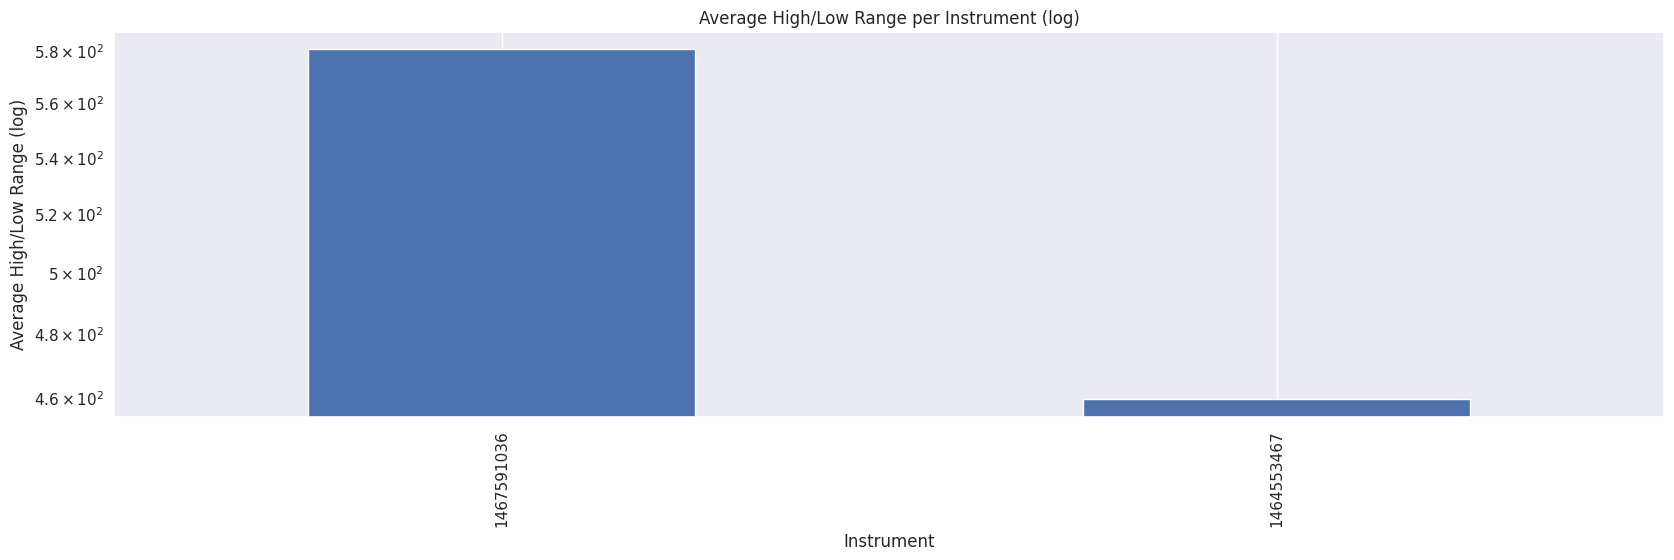

In [78]:
# Calculate the high-low spread to tick ratio.
high_low_range = (ohlcv_bars["high"] - ohlcv_bars["low"]) / price_tick_srs
# Plot average.
high_low_range.mean().sort_values(ascending=False).plot(
    kind="bar",
    logy=True,
    title="Average High/Low Range per Instrument (log)",
    xlabel="Instrument",
    ylabel="Average High/Low Range (log)",
)

# Child order DF stats

## Volatility

In [79]:
# Average volatility in bps by asset.
# Note: `mean()` used as a placeholder.
child_order_df.groupby("asset_id")["total_vol_bps"].mean()

asset_id
1464553467    1.838850
1467591036    1.154928
Name: total_vol_bps, dtype: float64

<Axes: >

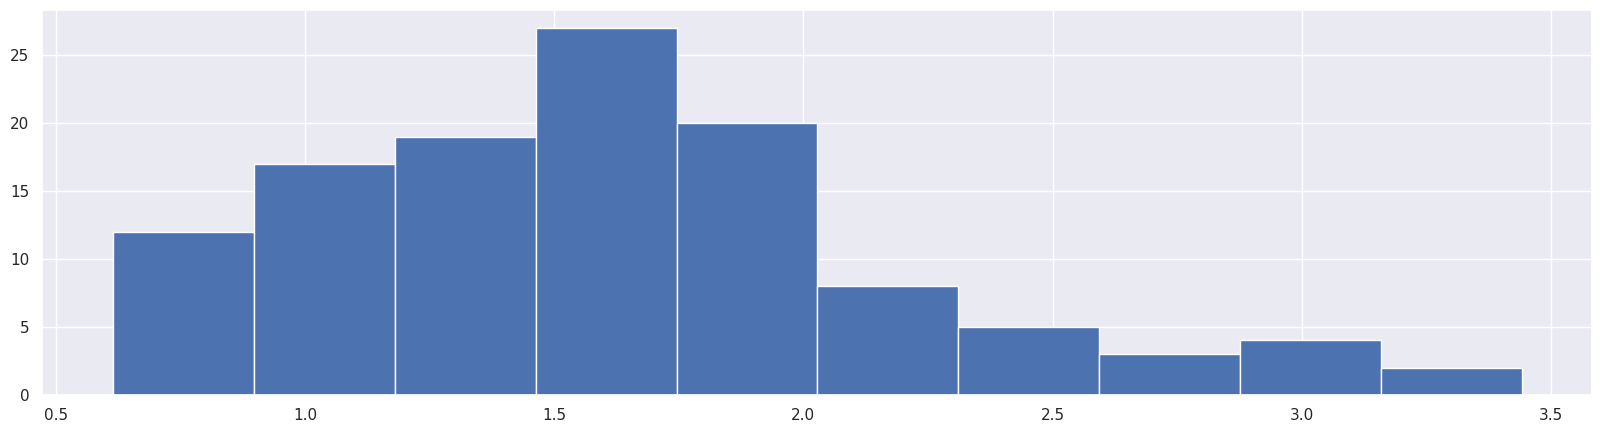

In [80]:
# Total volatility in bps histogram.
child_order_df["total_vol_bps"].hist()

## Bid/ask

In [81]:
# Average bid cost by asset.
avg_bid_price_by_asset = child_order_df.groupby("asset_id")[
    "latest_bid_price"
].mean()
_LOG.info(avg_bid_price_by_asset)
avg_bid_size_by_asset = child_order_df.groupby("asset_id")[
    "latest_bid_size"
].mean()
_LOG.info(avg_bid_size_by_asset)
avg_bid_cost_by_asset = avg_bid_price_by_asset * avg_bid_size_by_asset
avg_bid_cost_by_asset

INFO  asset_id
1464553467     2910.364304
1467591036    52206.910526
Name: latest_bid_price, dtype: float64
INFO  asset_id
1464553467    38.178823
1467591036     6.084000
Name: latest_bid_size, dtype: float64


asset_id
1464553467    111114.282994
1467591036    317626.843642
dtype: float64

In [82]:
# Average ask cost by asset.
avg_ask_price_by_asset = child_order_df.groupby("asset_id")[
    "latest_ask_price"
].mean()
_LOG.info(avg_ask_price_by_asset)
avg_ask_size_by_asset = child_order_df.groupby("asset_id")[
    "latest_ask_size"
].mean()
_LOG.info(avg_ask_size_by_asset)
avg_ask_cost_by_asset = avg_ask_price_by_asset * avg_ask_size_by_asset
avg_ask_cost_by_asset

INFO  asset_id
1464553467     2910.374304
1467591036    52207.010526
Name: latest_ask_price, dtype: float64
INFO  asset_id
1464553467    51.308937
1467591036     6.344316
Name: latest_ask_size, dtype: float64


asset_id
1464553467    149328.210953
1467591036    331217.761203
dtype: float64

# Analyze filled orders

In [83]:
# Group child orders by corresponding parent order.
child_order_df["parent_order_id"] = child_order_df.extra_params.apply(
    lambda x: x["oms_parent_order_id"]
)
child_order_df_by_parent = child_order_df.reset_index().set_index(
    ["parent_order_id", "order_id"]
)

## Filled order slippage normalized by parent order

Calculate filled order slippage as a difference between the bid/ask midpoint at the start of the parent order execution and the execution price of the filled order.

In [84]:
first_mid_price_by_parent = child_order_df_by_parent.groupby(level=0)[
    "latest_mid_price"
].first()

In [85]:
# Add filled order slippage for each child order.
child_order_df_by_parent["order_slippage"] = (
    first_mid_price_by_parent - child_order_df_by_parent["limit_price"]
)

In [86]:
# Filter to only unfilled child orders.
filled_child_order_df = child_order_df_by_parent[
    child_order_df_by_parent["ccxt_id"].isin(filled_ccxt_orders.index)
]
filled_child_order_df[["asset_id", "order_slippage"]]

,,asset_id,order_slippage
parent_order_id,order_id,,
1,7,1464553467,0.075
28,34,1464553467,0.175
62,66,1464553467,0.575
67,69,1464553467,0.745
72,76,1464553467,-0.135
100,104,1464553467,0.295
111,113,1464553467,0.535
115,119,1464553467,-0.155
122,128,1464553467,0.685


# Analyze unfilled orders

## Underfill execution quality

### Underfill notional

In [87]:
# Get the total underfill notional for the run per asset.
execution_quality_df["underfill_notional"].abs().sum()

1464553467    2.118987e+03
1467591036    3.168177e-13
dtype: float64

In [88]:
# Get the total underfill notional for the run per bar.
execution_quality_df["underfill_notional"].abs().sum(axis=1)

2024-02-19 15:09:00+00:00    0.000000e+00
2024-02-19 15:12:00+00:00    0.000000e+00
2024-02-19 15:15:00+00:00    1.453970e+01
2024-02-19 15:18:00+00:00    0.000000e+00
2024-02-19 15:21:00+00:00    0.000000e+00
2024-02-19 15:24:00+00:00    1.802076e+03
2024-02-19 15:27:00+00:00    0.000000e+00
2024-02-19 15:30:00+00:00    0.000000e+00
2024-02-19 15:33:00+00:00    0.000000e+00
2024-02-19 15:36:00+00:00    2.912320e+00
2024-02-19 15:39:00+00:00    2.994591e+02
2024-02-19 15:42:00+00:00    0.000000e+00
2024-02-19 15:45:00+00:00    0.000000e+00
2024-02-19 15:48:00+00:00    1.809528e-13
2024-02-19 15:51:00+00:00    0.000000e+00
2024-02-19 15:54:00+00:00    8.551394e-14
2024-02-19 15:57:00+00:00    0.000000e+00
2024-02-19 16:00:00+00:00    0.000000e+00
2024-02-19 16:03:00+00:00    0.000000e+00
2024-02-19 16:06:00+00:00    0.000000e+00
2024-02-19 16:09:00+00:00    0.000000e+00
2024-02-19 16:12:00+00:00    0.000000e+00
Freq: 3T, dtype: float64

In [89]:
# Get the total underfill notional.
execution_quality_df["underfill_notional"].abs().sum().sum()

2118.9867700000004

### Aggregate fill rate

In [90]:
underfill_notional = execution_quality_df["underfill_notional"].abs().sum()
executed_volume_notional = portfolio_df["executed_trades_notional"].abs().sum()
executed_volume_notional / (underfill_notional + executed_volume_notional)

asset_id
1464553467    0.84321
1467591036    1.00000
dtype: float64

In [91]:
# Total portfolio aggregate fill rate.
total_underfill_notional = underfill_notional.sum()
total_executed_volume_notional = executed_volume_notional.sum()
total_executed_volume_notional / (
    total_underfill_notional + total_executed_volume_notional
)

0.908561466003236

### Underfill share count

In [92]:
# Get underfill share count per asset.
execution_quality_df["underfill_share_count"].abs().sum().round(9)

1464553467    0.727
1467591036    0.000
dtype: float64

### Notional slippage

In [93]:
# Total slippage.
execution_quality_df["slippage_notional"].abs().sum().sum().round(9)

18.79936

In [94]:
# Notional slippage by asset.
execution_quality_df["slippage_notional"].abs().sum().round(9)

1464553467    11.41066
1467591036     7.38870
dtype: float64

In [95]:
# Slippage in bps by timestamp.
execution_quality_df["slippage_notional"].abs().sum(axis=1).round(9)

2024-02-19 15:09:00+00:00    0.00000
2024-02-19 15:12:00+00:00    0.71532
2024-02-19 15:15:00+00:00    0.00000
2024-02-19 15:18:00+00:00    0.00000
2024-02-19 15:21:00+00:00    5.31625
2024-02-19 15:24:00+00:00    1.21880
2024-02-19 15:27:00+00:00    1.65356
2024-02-19 15:30:00+00:00    0.00000
2024-02-19 15:33:00+00:00    2.80732
2024-02-19 15:36:00+00:00    0.74592
2024-02-19 15:39:00+00:00    0.10500
2024-02-19 15:42:00+00:00    0.78067
2024-02-19 15:45:00+00:00    0.35860
2024-02-19 15:48:00+00:00    4.35772
2024-02-19 15:51:00+00:00    0.00000
2024-02-19 15:54:00+00:00    0.19790
2024-02-19 15:57:00+00:00    0.00000
2024-02-19 16:00:00+00:00    0.54230
2024-02-19 16:03:00+00:00    0.00000
2024-02-19 16:06:00+00:00    0.00000
2024-02-19 16:09:00+00:00    0.00000
2024-02-19 16:12:00+00:00    0.00000
Freq: 3T, dtype: float64

### Slippage in bps adjusted by total executed volume

In [96]:
# Total.
execution_quality_df[
    "slippage_notional"
].abs().sum().sum() * 1e4 / executed_volume_notional.sum().round(9)

8.928731439634085

In [97]:
# By asset.
execution_quality_df[
    "slippage_notional"
].abs().sum() * 1e4 / executed_volume_notional.round(9)

1464553467    10.013055
1467591036     7.649452
dtype: float64

In [98]:
# By timestamp.
execution_quality_df["slippage_notional"].abs().sum(axis=1) * 1e4 / portfolio_df[
    "executed_trades_notional"
].abs().sum(axis=1).round(9)

2024-02-19 15:09:00+00:00          NaN
2024-02-19 15:12:00+00:00     4.814634
2024-02-19 15:15:00+00:00          NaN
2024-02-19 15:18:00+00:00          NaN
2024-02-19 15:21:00+00:00    17.953349
2024-02-19 15:24:00+00:00    10.591276
2024-02-19 15:27:00+00:00     9.185223
2024-02-19 15:30:00+00:00          NaN
2024-02-19 15:33:00+00:00     9.518367
2024-02-19 15:36:00+00:00    12.217028
2024-02-19 15:39:00+00:00     3.350969
2024-02-19 15:42:00+00:00     5.193876
2024-02-19 15:45:00+00:00     3.124257
2024-02-19 15:48:00+00:00    14.724167
2024-02-19 15:51:00+00:00          NaN
2024-02-19 15:54:00+00:00     3.517386
2024-02-19 15:57:00+00:00          NaN
2024-02-19 16:00:00+00:00     1.776424
2024-02-19 16:03:00+00:00          NaN
2024-02-19 16:06:00+00:00          NaN
2024-02-19 16:09:00+00:00     0.000000
2024-02-19 16:12:00+00:00          NaN
Freq: 3T, dtype: float64

### Slippage in bps over volatility

In [99]:
execution_quality_df["slippage_in_bps"].mean() / average_spread_bps

1464553467     22.931228
1467591036    146.489948
dtype: float64

## Compute vol-adjusted close price

In [100]:
# Get `close` price as defined in `get_adjusted_close_price` docstring.
child_order_df_by_parent["close"] = child_order_df_by_parent.groupby(level=0)[
    "latest_mid_price"
].shift(-1)
# Calculate volatility-adjusted close price.
adjusted_close = list(
    map(
        obccexqu.get_adjusted_close_price,
        child_order_df_by_parent["close"],
        child_order_df_by_parent["latest_mid_price"],
        child_order_df_by_parent["total_vol"],
    )
)
child_order_df_by_parent["adj_close"] = adjusted_close

In [101]:
# Filter to only unfilled child orders.
unfilled_child_order_df = child_order_df_by_parent[
    child_order_df_by_parent["ccxt_id"].isin(unfilled_ccxt_orders.index)
]
unfilled_child_order_df.head(3)

creation_timestamp    asset_id  type_                  start_timestamp             end_timestamp  curr_num_shares  diff_num_shares                tz                                       extra_params  volatility_multiple  wave_id  num_data_points               exchange_timestamp              knowledge_timestamp           end_download_timestamp  latest_bid_size  latest_ask_size  num_data_points_resampled  scaling_multiplier   bid_vol  bid_vol_bps  latest_bid_price   ask_vol  ask_vol_bps  latest_ask_price  total_vol  latest_mid_price  total_vol_bps  spread  spread_bps  total_vol_to_spread_bps  limit_price              ccxt_id  name  attempt_num  order_slippage     close  adj_close
parent_order_id order_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
1               3        2024-02-19 15:09:05.307975+00:00  1464553467  limit 2024-02-19 15:09:05.307975+00:00 2024-02-19 15:09:10+00:00            0.000           -0.206  America/New_York  {'stats': {'_submit_twap_child_order::wave_id'...                  1.5        0              289 2024-02-19 15:09:04.730000+00:00 2024-02-19 15:09:04.848809+00:00 2024-02-19 15:09:04.826719+00:00           87.550          110.968                        598                10.0  0.466068     1.603819           2905.99  0.467002     1.607025           2906.00   0.466535          2905.995       1.605423    0.01    0.034412                46.653504      2906.69  8389765653578981373     3            1          -0.695  2905.995   0.000000
                5        2024-02-19 15:09:10.226783+00:00  1464553467  limit 2024-02-19 15:09:10.226783+00:00 2024-02-19 15:09:20+00:00            0.000           -0.206  America/New_York  {'stats': {'_submit_twap_child_order::wave_id'...                  0.7        1              288 2024-02-19 15:09:09.704000+00:00 2024-02-19 15:09:09.794508+00:00 2024-02-19 15:09:09.779835+00:00           36.281          105.437                        597                10.0  0.377625     1.299471           2905.99  0.378779     1.303436           2906.00   0.378202          2905.995       1.301455    0.01    0.034412                37.820221      2906.25  8389765653578987144     5            1          -0.255  2905.665  -0.872549
28              30       2024-02-19 15:18:04.770221+00:00  1464553467  limit 2024-02-19 15:18:04.770221+00:00 2024-02-19 15:18:10+00:00           -0.206            0.515  America/New_York  {'stats': {'_submit_twap_child_order::wave_id'...                  1.5        0              289 2024-02-19 15:18:04.248000+00:00 2024-02-19 15:18:04.292698+00:00 2024-02-19 15:18:04.278201+00:00           38.046            8.077                        598                10.0  0.413061     1.419577           2909.75  0.413061     1.419572           2909.76   0.413061          2909.755       1.419575    0.01    0.034367                41.306145      2909.14  8389765653580734017    30            1           0.615  2909.915   0.387352

In [102]:
# Separate unfilled child orders by side.
unfilled_child_order_df_buy = unfilled_child_order_df[
    unfilled_child_order_df["diff_num_shares"] > 0
]
unfilled_child_order_df_sell = unfilled_child_order_df[
    unfilled_child_order_df["diff_num_shares"] < 0
]

In [103]:
# Display mean adjusted close by side.
_LOG.info(
    "Mean adjusted close for unfilled buy orders: %s",
    unfilled_child_order_df_buy["adj_close"].dropna().mean(),
)
_LOG.info(
    "Mean adjusted close for unfilled sell orders: %s",
    unfilled_child_order_df_sell["adj_close"].dropna().mean(),
)

INFO  Mean adjusted close for unfilled buy orders: 0.053802874049289254
INFO  Mean adjusted close for unfilled sell orders: -0.27028136906526395


In [104]:
# Display mean adjusted close by wave_id, buy orders.
unfilled_child_order_df_buy.groupby("wave_id")["adj_close"].mean().round(9)

wave_id
0     0.031641
1    -0.131293
2    -0.430497
3     0.570673
4     0.717666
5    -0.310458
6     1.469788
7     1.527835
8     2.352827
9    -1.795096
10   -0.455508
11    0.000000
12   -1.092249
13    0.662513
14    1.719764
15   -0.379193
16   -3.737033
17         NaN
Name: adj_close, dtype: float64

In [105]:
# Display mean adjusted close by wave_id, sell orders.
unfilled_child_order_df_sell.groupby("wave_id")["adj_close"].mean().round(9)

wave_id
0     0.181408
1    -1.513059
2    -0.605007
3    -0.933533
4    -0.175855
5    -0.276706
6    -0.392200
7     4.166355
8    -1.241858
9    -1.854860
10    0.879851
11   -0.460390
12    3.414714
13    1.522937
14    0.000000
15    1.173141
16    1.439902
17         NaN
Name: adj_close, dtype: float64

# Config after notebook run

In [106]:
print(config.to_string(mode="verbose"))

meta (marked_as_used=False, writer=None, val_type=core.config.config_.Config): 
  id_col (marked_as_used=True, writer=/tmp/ipykernel_484/2494311235.py::5::<module>, val_type=str): asset_id
  use_historical (marked_as_used=False, writer=None, val_type=bool): True
system_log_dir (marked_as_used=True, writer=/tmp/ipykernel_484/3320136017.py::2::<module>, val_type=str): /shared_data/ecs/test/system_reconciliation/C12a/prod/20240219_150900.20240219_160600/system_log_dir.manual/process_forecasts
ohlcv_market_data (marked_as_used=False, writer=None, val_type=core.config.config_.Config): 
  vendor (marked_as_used=True, writer=/tmp/ipykernel_484/171793047.py::4::<module>, val_type=str): CCXT
  mode (marked_as_used=True, writer=/tmp/ipykernel_484/171793047.py::10::<module>, val_type=str): trade
  universe (marked_as_used=False, writer=None, val_type=core.config.config_.Config): 
    universe_version (marked_as_used=True, writer=/tmp/ipykernel_484/171793047.py::1::<module>, val_type=str): v7.5
  